Visualize EV results - average of 40 runs, time since wind change

## load data
based on JH_model_fitting.py

In [ ]:
import os
import sys
import numpy as np

# eval_pkl = '/src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.001_debug_yes_vec_norm_train_actor_std/eval/plume_14421_37e2cd4be4c96943d0341849b40f81eb/noisy3x5b5.pkl'
eval_pkl = '/src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.001_debug_yes_vec_norm_train_actor_std/eval/plume_3492_45513dd8ac9d9cdbb3a34f957436f7af/noisy3x5b5.pkl'
obs_pkl = eval_pkl.replace(".pkl", "_observability_test.pkl")
eval_folder = os.path.dirname(eval_pkl) + '/'
dataset = os.path.basename(eval_pkl).replace('.pkl', '')
# K = int(sys.argv[2]) # number of states
# seed = int(sys.argv[3]) # number of instances
# np.random.seed(seed)

model_name = os.path.basename(os.path.dirname(eval_folder)).split('_')[1]
print(f"now visualizing {model_name}, {dataset}")
# out_fname = f"HMMGLM_seed{model_name}_randSeed{seed}_K{K}.npz"
# out_path = os.path.join(eval_folder, out_fname)
# print(f"results will be saved to {out_path}")

now visualizing 3492, noisy3x5b5


In [308]:
# load pkl file
import pickle
import seaborn as sns
import pandas as pd
import numpy as np
import tamagotchi.eval.log_analysis as log_analysis

# with open(obs_pkls[0], 'rb') as f_handle:
with open(obs_pkl, 'rb') as f_handle:
    observability_tupl = pickle.load(f_handle)
    print(len(observability_tupl))
# with open(eval_pkls[0], 'rb') as f_handle:
with open(eval_pkl, 'rb') as f_handle:
    # based on open_loop_perturbation.py
    selected_df = log_analysis.get_selected_df(eval_folder, [dataset],
                                            n_episodes_home=240,
                                            n_episodes_other=240,  
                                            balanced=False,
                                            oob_only=False,
                                            verbose=True)

    traj_df_stacked, stacked_neural_activity = log_analysis.get_traj_and_activity_and_stack_them(selected_df, 
                                                                                                obtain_neural_activity = True, 
                                                                                                obtain_traj_df = True, 
                                                                                                get_traj_tmp = True,
                                                                                                extended_metadata = True) # get_traj_tmp 
    print(traj_df_stacked.shape)
    print(stacked_neural_activity.shape)
# for item in observability_tupl:
#     EV_no_nan, t_sim, x_sim, window_size, eps_idx = item
    
# ls_EV_no_nan, ls_t_sim, ls_x_sim, ls_window_size, ls_eps_idx = zip(*observability_tupl)

# # Preprocess the trajectory data
# # select episodes that have observability matrices
eps_at = [True for ep_i in traj_df_stacked['ep_idx'] ]
subset_traj_df_stacked = traj_df_stacked[eps_at]
# subset_stacked_neural_activity = stacked_neural_activity[eps_at]

# # for every episode, drop the last row
subset_traj_df_stacked.reset_index(drop=True, inplace=True)
last_rows = subset_traj_df_stacked.groupby('ep_idx').tail(1).index
# print('dropping', len(last_rows), 'rows, which are the last rows of each episode') # drop because there's no terminal+1 state
# # drop the last row of each episode
filtered_df = subset_traj_df_stacked.drop(index=last_rows)
# filtered_neural_activity = np.delete(subset_stacked_neural_activity, last_rows, axis=0)

# # calculate time since last wind change
#     # based on /src/JH_boilerplate/agent_evaluatiion/traj_analysis_preprocess.ipynb
filtered_df = filtered_df.groupby('ep_idx').apply(log_analysis.calc_time_since_last_wind_change).reset_index(drop=True)

# # create time column in filtered_df to match with EV_no_nan, starting from 0 to trial end 
filtered_df['time'] = filtered_df.groupby('ep_idx')['t_val'].transform(lambda x: x - x.iloc[0])
filtered_df['time'] = filtered_df['time'].round(2)
# filtered_df['turn'] = (filtered_df['turn'] * 2) - 1 # center the turn values at 0 (from 0~1 to -1~1)

# # first derivative of actions based on obs_df calculations 
# filtered_df['heading_phi'] = np.angle(filtered_df['agent_angle_x']+ 1j*filtered_df['agent_angle_y'], deg=False)
# filtered_df['heading_phi_unwrap'] = np.unwrap(np.angle(filtered_df['agent_angle_x']+ 1j*filtered_df['agent_angle_y'], deg=False))
# filtered_df['angular_velocity'] = filtered_df.groupby('ep_idx')['heading_phi_unwrap'].diff() # not really v - just once step difference
# filtered_df['angular_acceleration'] = filtered_df.groupby('ep_idx')['angular_velocity'].diff()
# filtered_df['turn_dt'] = filtered_df['angular_acceleration'] / (6 * np.pi) # 
# filtered_df['turn_dt'] = filtered_df['turn_dt'].abs() # 
# filtered_df['step_dt'] = filtered_df.groupby('ep_idx')['step'].diff()

# # drop rows with NaN
# # filtered_df.dropna(inplace=True)

# print("filtered_df shape", filtered_df.shape)
# print("filtered_neural_activity shape", filtered_neural_activity.shape)

# # Preprocess the EV data 
# # stack the EV data
# ls_EV_no_nan = [df.assign(ep_idx=ep_idx) for df, ep_idx in zip(ls_EV_no_nan, ls_eps_idx)]
# EV_no_nan = pd.concat(ls_EV_no_nan)
# print(EV_no_nan.shape)
# # Merge with filtered_dfa
# EV_no_nan['time'] = EV_no_nan['time'].round(2)
# EV_no_nan = EV_no_nan.merge(filtered_df[['ep_idx', 'time', 'time_since_last_wind_change', 
#                                          'odor_lastenc', 'odor_01', 'step', 'turn', 'step_dt', 'turn_dt', 'loc_x', 'loc_y']], on=['ep_idx', 'time'], how='inner')
# print(EV_no_nan.shape)
# '''
# # # Preprocess action data
# # # get speed and acceleration
# # obs_df = pd.DataFrame()
# # obs_df['ep_idx'] = filtered_df['ep_idx']
# # obs_df['step'] = filtered_df['step'] # squashed action
# # obs_df['step_dt'] = obs_df.groupby('ep_idx')['step'].diff()
# # obs_df['speed'] = filtered_df['step']*2 # in m/s unit
# # obs_df['acceleration'] = obs_df.groupby('ep_idx')['speed'].diff()
# # obs_df['turn'] = ((filtered_df['turn'] - 0.5)*2)
# # obs_df['angular_velocity_turn'] = obs_df['turn'] * (6*np.pi) # in rad/s unit

# # # obs_df['acceleration'] = obs_df['acceleration'].fillna(0) # TODO check timing 

# # # calculate angular velocity and angular acceleration
# # obs_df['heading_phi'] = np.angle(filtered_df['agent_angle_x']+ 1j*filtered_df['agent_angle_y'], deg=False)
# # obs_df['heading_phi_unwrap'] = np.unwrap(np.angle(filtered_df['agent_angle_x']+ 1j*filtered_df['agent_angle_y'], deg=False))
# # obs_df['angular_velocity'] = obs_df.groupby('ep_idx')['heading_phi_unwrap'].diff()
# # obs_df['angular_acceleration'] = obs_df.groupby('ep_idx')['angular_velocity'].diff()
# # # obs_df['angular_acceleration'] = obs_df['angular_acceleration'].fillna(0) # TODO check timing

# # # set 10% trials as test set
# # test_idx = np.random.choice(obs_df['ep_idx'].unique(), int(0.1*len(obs_df['ep_idx'].unique())), replace=False)
# # obs_df['train_test_label'] = 'train'
# # obs_df.loc[obs_df['ep_idx'].isin(test_idx), 'train_test_label'] = 'test'
# # # print how many train and test episodes
# # print(obs_df.groupby('train_test_label')['ep_idx'].nunique())
# # print(obs_df[obs_df['train_test_label']=='test'].groupby('train_test_label')['ep_idx'].unique())

# # input_df = pd.DataFrame()
# # # observations of the agent
# # input_df['ep_idx'] = filtered_df['ep_idx']
# # input_df['app_wind_x'] = filtered_df['wind_x_obs']
# # input_df['app_wind_y'] = filtered_df['wind_y_obs']
# # input_df['odor'] = filtered_df['odor_eps_log']
# # input_df['allo_head_phi_x'] = filtered_df['agent_angle_x']
# # input_df['allo_head_phi_y'] = filtered_df['agent_angle_y']
# # input_df['ego_drift_x'] = filtered_df['ego_course_direction_x']
# # input_df['ego_drift_y'] = filtered_df['ego_course_direction_y']
# # # possible latents to include
# # input_df['min_EV_zeta'] = EV_no_nan['zeta']
# # input_df['time_since_last_wind_change'] = EV_no_nan['time_since_last_wind_change']
# # input_df['acceleration'] = obs_df['acceleration']
# # input_df['angular_acceleration'] = obs_df['angular_acceleration']

# # # set 10% trials as test set
# # input_df['train_test_label'] = obs_df['train_test_label']
# # print(input_df.groupby('train_test_label')['ep_idx'].nunique())
# # print(obs_df[obs_df['train_test_label']=='test'].groupby('train_test_label')['ep_idx'].unique())
# # train_idx = input_df[input_df['train_test_label']=='train']['ep_idx'].unique()
# # # drop rows with NaN
# # input_df.dropna(inplace=True)
# # obs_df.dropna(inplace=True)
# '''

40
Found                     idx  ep_length  log
dataset    outcome                     
noisy3x5b5 HOME      99         99   99
           OOB      141        141  141 in /src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.001_debug_yes_vec_norm_train_actor_std/eval/plume_3492_45513dd8ac9d9cdbb3a34f957436f7af//noisy3x5b5.pkl, after filter by min 0 steps
Found                     idx  ep_length  log
dataset    outcome                     
noisy3x5b5 HOME      99         99   99
           OOB      141        141  141 in /src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.001_debug_yes_vec_norm_train_actor_std/eval/plume_3492_45513dd8ac9d9cdbb3a34f957436f7af//noisy3x5b5.pkl, after selecting specific number of episodes
model_dir /src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.001_debug_yes_vec_norm_train_actor_std/eval/plume_3492_45513dd8ac9d9cdbb3a34f957436f7af/
model_seed ----> 3492
Found 34 .pkl evaluation log

240it [00:29,  8.09it/s]


(38503, 91)
(38503, 64)


check if wind change detection is working

In [46]:
# based on /src/JH_boilerplate/agent_evaluatiion/wind_encoding_perturbation/analyze_OL_perturb_trajj.ipynb
def tidx_around_wind_change(df_traj, around_range=40, drop_incomplete=True, verbose=False):
    # df_traj contains the KL divergence data and the time since the last wind change
    # get +- around_range index around which wind changed
    # returns df_traj_aligned: a subset of df_traj, with only the rows around which wind changed, and plot_tidx around wind change, instead of actual tidx
    idx_where_wind_changed = df_traj[df_traj['time_since_last_wind_change']==0].index
    if verbose:
        print(f"starting with df.shape {df_traj.shape}")
        print(f"with {df_traj['ep_idx'].nunique()} eps")
        # max_rep = np.max(np.array([int(hash.split('_')[-2]) for hash in df_traj['ep_idx']])) + 1
        # print(f"and up to {max_rep} reps")
        print(f"total number of wind change {len(idx_where_wind_changed)}")
    if drop_incomplete:
        print(f"dropping incomplete time windows, where +- {around_range} around wind change is out of range")
    
    # get index around which wind changed
    df_traj_grouped = df_traj.groupby('ep_idx')
    idx_around_wind_change = []
    tidx_for_plotting = []
    eligible_wind_change_idx = []
    for _, ep_df in df_traj_grouped:
        idx_where_wind_changed = ep_df[ep_df['time_since_last_wind_change']==0].index
        for wind_changed_idx in idx_where_wind_changed:
            # check if -5/+5 is out of range
            upper_bound = wind_changed_idx + around_range
            lower_bound = wind_changed_idx - around_range
            if upper_bound >= ep_df.index.max():
                if drop_incomplete:
                    continue
                upper_bound = ep_df.index.max()
            if lower_bound < ep_df.index.min():
                if drop_incomplete: 
                    continue
                lower_bound = ep_df.index.min()
            # get index around which wind changed
            now_idx_range = [i for i in range(lower_bound, upper_bound + 1)] # loc index of rows around wind change
            idx_around_wind_change.append(now_idx_range)
            tidx_for_plotting.append(list(np.array(now_idx_range) - wind_changed_idx)) # time index aligned to wind change, where wind change is 0 and prior to wind change is negative
            eligible_wind_change_idx.append(wind_changed_idx)
    # subset df and add plot_tidx
    idx_around_wind_change = [item for sublist in idx_around_wind_change for item in sublist]
    sub_df = df_traj.loc[idx_around_wind_change]
    sub_df['plot_tidx'] = [item for sublist in tidx_for_plotting for item in sublist]
    print(f"[NOTE]: number of eligible unique wind change instances {len(set(eligible_wind_change_idx))}")
    if verbose:
        print(f"returning sub_df.shape {sub_df.shape}")
        print(f"with {sub_df['ep_idx'].nunique()} eps")
        # intersection bewteen eps in sub_df and eps in df_traj
        
        print(f"eps {set(df_traj['ep_idx'].unique()) - set(sub_df['ep_idx'].unique())} did not have any eligible wind change windows")
    return sub_df

EV_no_nan_around = tidx_around_wind_change(EV_no_nan, around_range=40, drop_incomplete=False, verbose=True)
EV_no_nan_around.head(10)

,wind_angle_ground_theta,time_since_last_wind_change,odor_lastenc,odor_01,step,turn,step_dt,turn_dt
0,0.616313,0.04,0,1,0.243873,-0.806738,NaN,NaN
1,0.648936,0.00,0,1,0.352573,-0.845863,0.108700,NaN
2,0.648936,0.04,0,1,0.449508,-0.769184,0.096935,0.001597
3,0.648936,0.08,0,1,0.395366,-0.754988,-0.054142,0.000296
4,0.648936,0.12,0,1,0.372357,-0.785812,-0.023009,0.000642


# minEV evolution at wind change

## plot all minEV traces

In [ ]:
states = ['zeta']
n_state = len(states)
import matplotlib.pyplot as plt
import matplotlib as mpl
from pybounds import colorline
fig, ax = plt.subplots(n_state, 1, figsize=(6, n_state*1), dpi=150)
ax = np.atleast_2d(ax)
print(ax.shape)
cmap = 'inferno_r'

max_ev = np.max(EV_no_nan['zeta'].values)
min_ev = np.min(EV_no_nan['zeta'].values)

log_tick_high = int(np.ceil(np.log10(max_ev)))
log_tick_low = int(np.floor(np.log10(min_ev)))
cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

for n, state_name in enumerate(states):
    # colorline(x_sim['x'], x_sim['y'], EV_no_nan[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    colorline(EV_no_nan['time'], EV_no_nan[state_name].values, EV_no_nan[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)

    # Colorbar
    cax = ax[n, -1].inset_axes([1.03, 0.0, 0.04, 1.0])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                        ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    cbar.set_label('min. EV: ' + state_name, rotation=270, fontsize=7, labelpad=8)
    cbar.ax.tick_params(labelsize=6)

    ax[n, 0].set_ylim(10**log_tick_low, 10**log_tick_high)
    ax[n, 0].set_yscale('log')
    ax[n, 0].set_ylabel('min. EV: ' + state_name, fontsize=7)
    ax[n, 0].set_yticks(np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))


for a in ax.flat:
    a.tick_params(axis='both', labelsize=6)
    
for a in ax[:, 0]:
    a.set_xlabel('time (s)', fontsize=7)
    a.set_xlim(-0.1, EV_no_nan['time'].max() + 0.1)

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)

plt.show()

## plot one trace at wind change

<Axes: >

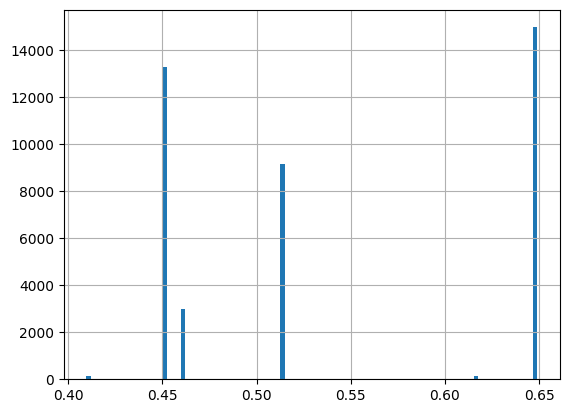

In [257]:
filtered_df['wind_angle_ground_theta'].hist(bins=100)

<Axes: >

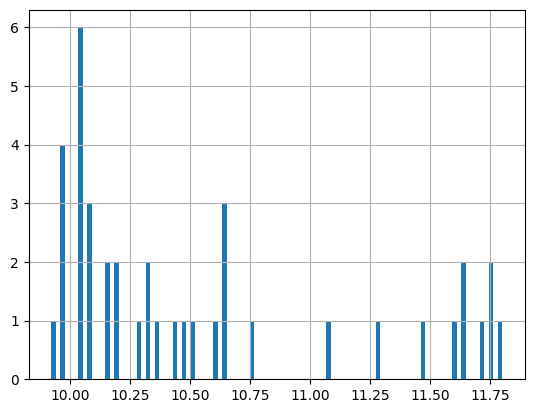

In [261]:
EV_no_nan.groupby('ep_idx')['time'].max().hist(bins=100)

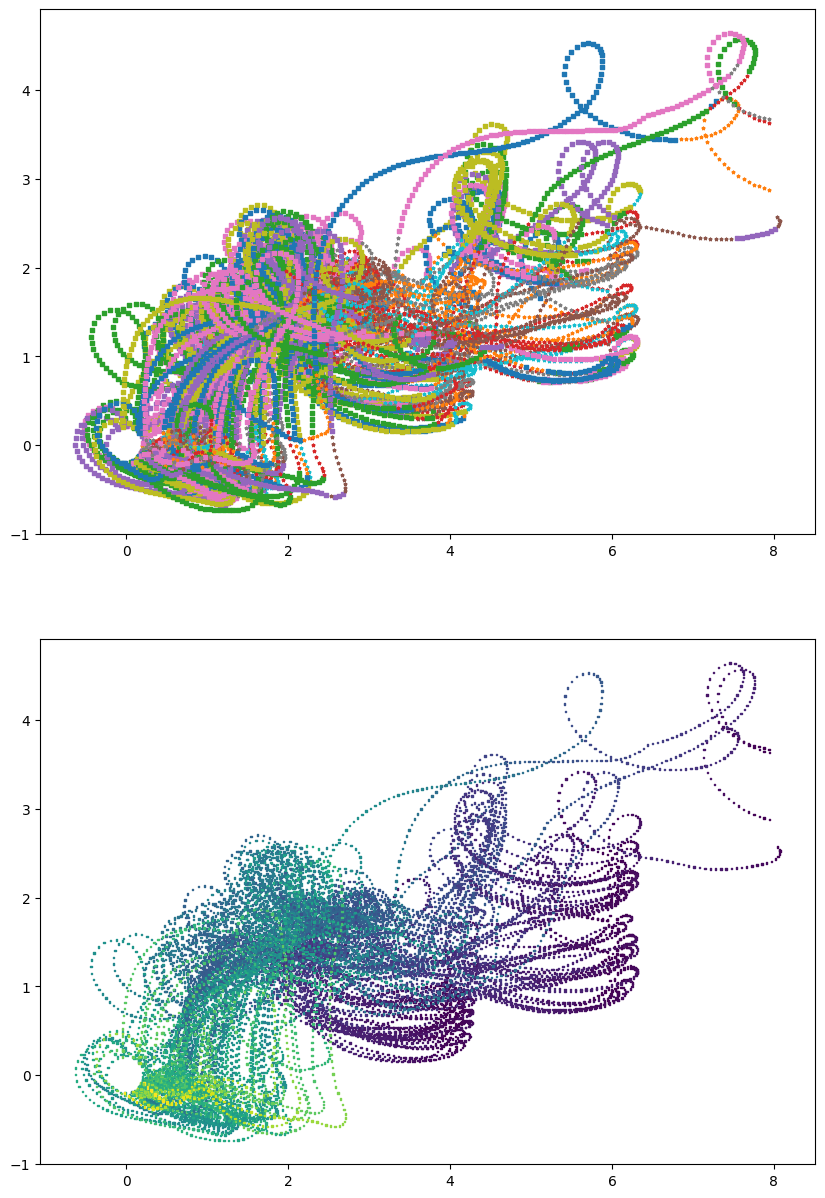

In [310]:

# plot ground truth
# plot each state in a separate plot, where x_sim is a dict 
# gt_dict['phi'] = np.unwrap(gt_dict['phi'])
# fig, axs = plt.subplots(7, 1, figsize=(10, 15)) # x y loc
fig, axs = plt.subplots(2, 1, figsize=(10, 15))
filtered_df_tmp = filtered_df[filtered_df['outcome'] == 'HOME'].copy()
filtered_df_tmp2 = filtered_df_tmp[filtered_df_tmp['time'] == 0 ].reset_index(drop=True)
# filtered_df_tmp2 = filtered_df_tmp2[filtered_df_tmp2['loc_x'] > 7].reset_index(drop=True)
# filtered_df_tmp2 = filtered_df_tmp2[filtered_df_tmp2['loc_x'] < 9].reset_index(drop=True)
max_time = np.max(filtered_df_tmp['time'].values)
min_time = np.min(filtered_df_tmp['time'].values)
cnorm = mpl.colors.Normalize(min_time, max_time)
for ep in filtered_df_tmp2['ep_idx'].unique():
# for ep in filtered_df_tmp2['ep_idx'].unique()[:20]:
    subset_df = filtered_df_tmp[filtered_df_tmp['ep_idx'] == ep]
    # max_ev = np.max(subset_df['zeta'].values)
    # min_ev = np.min(subset_df['zeta'].values)

    # log_tick_high = int(np.ceil(np.log10(max_ev)))
    # log_tick_low = int(np.floor(np.log10(min_ev)))
    # cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)
    


    for i, state_name in enumerate(['zeta']):
        # axs[i].plot(subset_df['loc_x'], subset_df['loc_y'], label='sim')
        tmp = subset_df[subset_df['odor_01']==0]
        axs[i].scatter(tmp['loc_x'], tmp['loc_y'], label='sim', marker='s', s=5)
        # axs[i].scatter(tmp['loc_x'], tmp['loc_y'], label='sim', c=tmp['zeta'], marker='s', cmap='inferno_r', norm=cnorm, s=1)
        tmp = subset_df[subset_df['odor_01']==1]
        axs[i].scatter(tmp['loc_x'], tmp['loc_y'], label='sim',  marker='*', s=5)
        # axs[i].scatter(tmp['loc_x'], tmp['loc_y'], label='sim', c=tmp['zeta'], marker='*', cmap='inferno_r', norm=cnorm, s=1)
        # tmp = subset_df[subset_df['time_since_last_wind_change']==0]
        # axs[i].scatter(tmp['loc_x'], tmp['loc_y'], label='sim', marker='x', s=100)
        i += 1 
        # axs[i].plot(subset_df['loc_x'], subset_df['loc_y'], label='sim')
        axs[i].scatter(subset_df['loc_x'], subset_df['loc_y'], label='sim', marker='s', s=1, c=subset_df['time'], norm=cnorm)
        # tmp = subset_df[subset_df['time_since_last_wind_change']==0]
        # axs[i].scatter(tmp['loc_x'], tmp['loc_y'], label='sim', marker='x', s=100)
        # axs[i].set_title(state_name)
        # axs[i].legend()
plt.show()

(1, 1)


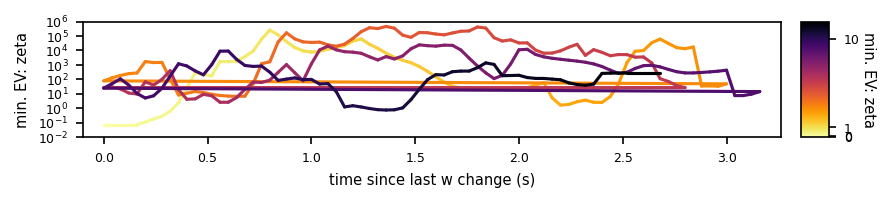

In [216]:
subset_df = EV_no_nan[EV_no_nan['ep_idx'] == 160]
states = ['zeta']
n_state = len(states)
import matplotlib.pyplot as plt
import matplotlib as mpl
from pybounds import colorline
fig, ax = plt.subplots(n_state, 1, figsize=(6, n_state*1), dpi=150)
ax = np.atleast_2d(ax)
print(ax.shape)
cmap = 'inferno_r'

max_ev = np.max(subset_df['time'].values)
min_ev = np.min(subset_df['time'].values)

# log_tick_high = int(np.ceil(np.log10(max_ev)))
# log_tick_low = int(np.floor(np.log10(min_ev)))
cnorm = mpl.colors.Normalize(min_ev, max_ev)
# cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

for n, state_name in enumerate(states):
    # colorline(x_sim['x'], x_sim['y'], subset_df[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    colorline(subset_df['time_since_last_wind_change'], subset_df[state_name].values, subset_df['time'].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)

    # Colorbar
    cax = ax[n, -1].inset_axes([1.03, 0.0, 0.04, 1.0])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                        ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    cbar.set_label('min. EV: ' + state_name, rotation=270, fontsize=7, labelpad=8)
    cbar.ax.tick_params(labelsize=6)

    ax[n, 0].set_ylim(10**log_tick_low, 10**log_tick_high)
    ax[n, 0].set_yscale('log')
    ax[n, 0].set_ylabel('min. EV: ' + state_name, fontsize=7)
    ax[n, 0].set_yticks(np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))


for a in ax.flat:
    a.tick_params(axis='both', labelsize=6)
    
for a in ax[:, 0]:
    a.set_xlabel('time since last w change (s)', fontsize=7)
    a.set_xlim(-0.1, subset_df['time_since_last_wind_change'].max() + 0.1)

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)

plt.show()

## plot avg. min EV around wind change

In [16]:
filtered_df[['wind_theta_obs', 'ep_idx']]

,wind_theta_obs,ep_idx
0,5.000000e-01,83
1,5.000000e-01,83
2,5.000000e-01,83
3,5.000000e-01,83
4,5.000000e-01,83
...,...,...
10603,7.541190e-13,236
10604,7.296386e-13,236
10605,6.846745e-13,236
10606,6.991629e-13,236


In [165]:
EV_no_nan.head(20)

,time,time_initial,v_para,v_perp,w,zeta,ep_idx,time_since_last_wind_change,odor_lastenc,odor_01,step,turn,step_dt,turn_dt
0,0.00,0.00,1.412335,0.388223,0.364682,0.073294,160,0.04,0,1,0.242632,-0.814600,NaN,NaN
1,0.04,0.00,1.412335,0.388223,0.364682,0.073294,160,0.00,0,1,0.347392,-0.858491,0.104760,NaN
2,0.08,0.00,1.412335,0.388223,0.364682,0.073294,160,0.04,0,1,0.440706,-0.787839,0.093314,0.001472
3,0.12,0.00,1.412335,0.388223,0.364682,0.073294,160,0.08,0,1,0.384857,-0.776971,-0.055850,0.000226
4,0.16,0.00,1.412335,0.388223,0.364682,0.073294,160,0.12,0,1,0.364993,-0.802025,-0.019863,0.000522
5,0.20,0.00,1.412335,0.388223,0.364682,0.073294,160,0.16,0,1,0.349013,-0.813825,-0.015980,0.000246
6,0.24,0.04,0.831043,0.413312,0.373693,0.110610,160,0.20,0,1,0.337804,-0.807168,-0.011209,0.000139
7,0.28,0.08,0.472731,0.311020,0.319010,0.177103,160,0.24,0,1,0.410547,-0.661528,0.072743,0.003034
8,0.32,0.12,0.252483,0.243326,0.309881,0.277348,160,0.28,0,1,0.682121,-0.327091,0.271574,0.006967
9,0.36,0.16,0.134703,0.140796,0.323768,0.615163,160,0.32,0,0,0.894053,-0.115457,0.211932,0.004409


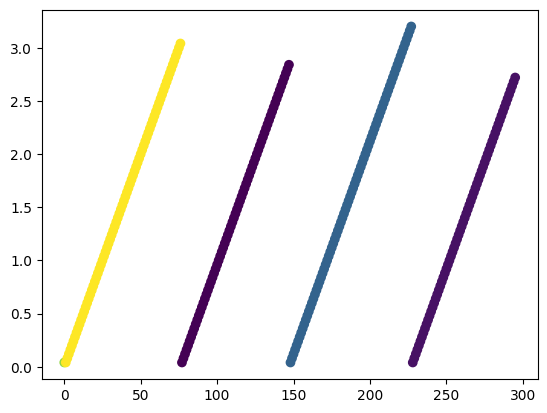

In [31]:
# filtered_df[filtered_df['ep_idx'] == 160]['wind_angle_ground_theta'].value_counts()

# Create a counter that counts consecutive occurrences within each group
x = filtered_df[filtered_df['ep_idx'] == 160].groupby(['ep_idx', 'wind_angle_ground_theta']).cumcount() + 1

x = x.reset_index()
x = x*0.04
# plot index of x on x-axis and the value of x on y-axis and color by wind_angle_ground_theta
plt.scatter(x.index, x[0], c=filtered_df[filtered_df['ep_idx'] == 160]['wind_angle_ground_theta'], cmap='viridis')


# find the iloc of the max of time_since_last_wind_change in each episode
# max_time_since_last_wind_change = filtered_df.groupby('ep_idx')['time_since_last_wind_change'].idxmax()
# [range(im-5, im+5) for im in max_time_since_last_wind_change]

   time_since_last_wind_change          zeta
0                         0.00    262.860720
1                         0.04    237.597462
2                         0.08    275.436331
3                         0.12    274.910994
4                         0.16    661.814631
5                         0.20  14926.943538
6                         0.24  19293.169109
7                         0.28  18537.182476
8                         0.32  19457.651930
9                         0.36  17535.542709
(1, 1)


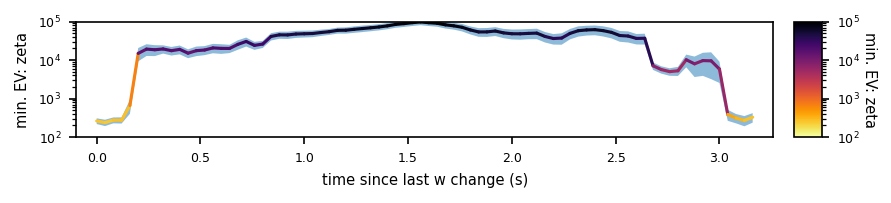

In [149]:
# plot average EV over time since last wind change with std ON plume
subset_df = EV_no_nan
subset_df = subset_df.groupby('time_since_last_wind_change')['zeta'].mean().reset_index()
print(subset_df.head(10))
subset_df['std'] = EV_no_nan.groupby('time_since_last_wind_change').std().reset_index()['zeta']
subset_df['ste'] = EV_no_nan.groupby('time_since_last_wind_change').sem().reset_index()['zeta']
states = ['zeta']
n_state = len(states)
import matplotlib.pyplot as plt
import matplotlib as mpl
from pybounds import colorline
fig, ax = plt.subplots(n_state, 1, figsize=(6, n_state*1), dpi=150)
ax = np.atleast_2d(ax)
print(ax.shape)
cmap = 'inferno_r'

max_ev = np.max(subset_df['zeta'].values)
min_ev = np.min(subset_df['zeta'].values)

log_tick_high = int(np.ceil(np.log10(max_ev)))
log_tick_low = int(np.floor(np.log10(min_ev)))
cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

for n, state_name in enumerate(states):
    # colorline(x_sim['x'], x_sim['y'], subset_df[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    colorline(subset_df['time_since_last_wind_change'], subset_df[state_name].values, subset_df[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    # add std
    ax[n, 0].fill_between(subset_df['time_since_last_wind_change'], subset_df[state_name].values-subset_df['ste'], subset_df[state_name].values+subset_df['ste'], alpha=0.5)
    # Colorbar
    cax = ax[n, -1].inset_axes([1.03, 0.0, 0.04, 1.0])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                        ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    cbar.set_label('min. EV: ' + state_name, rotation=270, fontsize=7, labelpad=8)
    cbar.ax.tick_params(labelsize=6)

    ax[n, 0].set_ylim(10**log_tick_low, 10**log_tick_high)
    ax[n, 0].set_yscale('log')
    ax[n, 0].set_ylabel('min. EV: ' + state_name, fontsize=7)
    ax[n, 0].set_yticks(np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))


for a in ax.flat:
    a.tick_params(axis='both', labelsize=6)
    
for a in ax[:, 0]:
    a.set_xlabel('time since last w change (s)', fontsize=7)
    a.set_xlim(-0.1, subset_df['time_since_last_wind_change'].max() + 0.1)

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)

plt.show()

<Axes: xlabel='time_since_last_wind_change', ylabel='Count'>

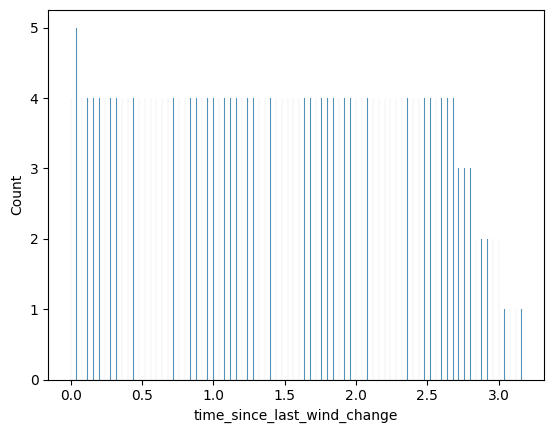

In [15]:
subset_df['time_since_last_wind_change']
# draw the distribution of time_since_last_wind_change
import seaborn as sns
sns.histplot(subset_df['time_since_last_wind_change'], bins=1000)

## plot OFF/ON traces

(2,)


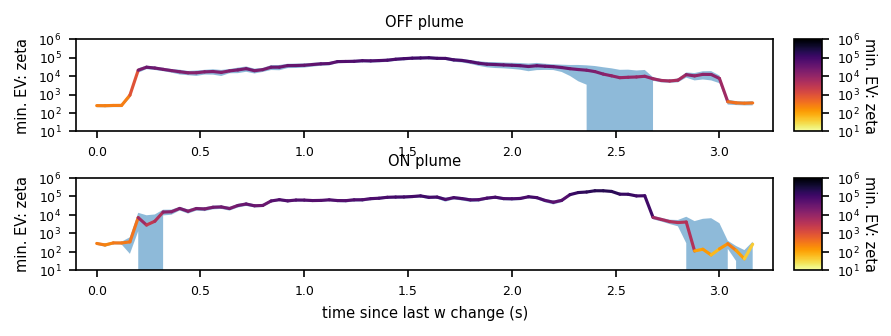

In [10]:
# plot average EV over time since last wind change with std ON plume


import matplotlib.pyplot as plt
import matplotlib as mpl
from pybounds import colorline
fig, ax = plt.subplots(2, 1, figsize=(6, 2), dpi=150) # 2 rows, off and on plume
print(ax.shape)
ax = np.atleast_2d(ax)
ax = ax.reshape(-1, 1)
cmap = 'inferno_r'

max_ev = np.max(subset_df['zeta'].values)
min_ev = np.min(subset_df['zeta'].values)

log_tick_high = int(np.ceil(np.log10(max_ev)))
log_tick_low = int(np.floor(np.log10(min_ev)))
# log_tick_low = 3
cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

state_name = 'zeta'
for n in range(2): # ON vs OFF plume
    subset_df = EV_no_nan[EV_no_nan['odor_01'] == n]
    subset_df = subset_df.groupby('time_since_last_wind_change')['zeta'].mean().reset_index()
    subset_df['std'] = EV_no_nan.groupby('time_since_last_wind_change').std().reset_index()['zeta']
    subset_df['ste'] = EV_no_nan.groupby('time_since_last_wind_change').sem().reset_index()['zeta']
    colorline(subset_df['time_since_last_wind_change'], subset_df[state_name].values, subset_df[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    # add std
    ax[n, 0].fill_between(subset_df['time_since_last_wind_change'], subset_df[state_name].values-subset_df['ste'], subset_df[state_name].values+subset_df['ste'], alpha=0.5)
    # Colorbar
    cax = ax[n, -1].inset_axes([1.03, 0.0, 0.04, 1.0])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                        ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    cbar.set_label('min. EV: ' + state_name, rotation=270, fontsize=7, labelpad=8)
    cbar.ax.tick_params(labelsize=6)

    ax[n, 0].set_ylim(10**log_tick_low, 10**log_tick_high)
    ax[n, 0].set_yscale('log')
    ax[n, 0].set_ylabel('min. EV: ' + state_name, fontsize=7)
    ax[n, 0].set_yticks(np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    # add label to row
    if n == 0:
        ax[n, 0].set_title('OFF plume')
    else:
        ax[n, 0].set_title('ON plume')
    # make title smaller
    ax[n, 0].title.set_size(7)


for a in ax.flat:
    a.tick_params(axis='both', labelsize=6)
    
for a in ax[:, 0]:
    a.set_xlim(-0.1, subset_df['time_since_last_wind_change'].max() + 0.1)
ax[1,0].set_xlabel('time since last w change (s)', fontsize=7)

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.5)

plt.show()

Maybe a dip after wind changes, and can check by plotting the trace preceeding to the wind change. But, the scale of the trace is problematic. One average wind should be hardly observable. It still may be possible if collected over a long time, since this is just min. EV and variance can be smoothed out by averaging.

## plot at +- wind change 

### preprocess 

In [148]:
# tidx_around_wind_change assumes that the df_traj has unique timestamps and that they are monotonically increasing

# check if time is monotonically increasing
EV_no_nan[EV_no_nan['ep_idx']==83]['time'].value_counts()

time
0.00     1
6.92     1
6.40     1
6.44     1
6.48     1
        ..
3.52     1
3.56     1
3.60     1
3.64     1
10.04    1
Name: count, Length: 252, dtype: int64

In [169]:
# based on /src/JH_boilerplate/agent_evaluatiion/wind_encoding_perturbation/analyze_OL_perturb_trajj.ipynb
def tidx_around_wind_change(df_traj, around_range=40, drop_incomplete=True, verbose=False):
    # df_traj contains the KL divergence data and the time since the last wind change
    # get +- around_range index around which wind changed
    # returns df_traj_aligned: a subset of df_traj, with only the rows around which wind changed, and plot_tidx around wind change, instead of actual tidx
    idx_where_wind_changed = df_traj[df_traj['time_since_last_wind_change']==0].index
    if verbose:
        print(f"starting with df.shape {df_traj.shape}")
        print(f"with {df_traj['ep_idx'].nunique()} eps")
        # max_rep = np.max(np.array([int(hash.split('_')[-2]) for hash in df_traj['ep_idx']])) + 1
        # print(f"and up to {max_rep} reps")
        print(f"total number of wind change {len(idx_where_wind_changed)}")
    if drop_incomplete:
        print(f"dropping incomplete time windows, where +- {around_range} around wind change is out of range")
    
    # get index around which wind changed
    df_traj_grouped = df_traj.groupby('ep_idx')
    idx_around_wind_change = []
    tidx_for_plotting = []
    eligible_wind_change_idx = []
    for _, ep_df in df_traj_grouped:
        idx_where_wind_changed = ep_df[ep_df['time_since_last_wind_change']==0].index
        for wind_changed_idx in idx_where_wind_changed:
            # check if -5/+5 is out of range
            upper_bound = wind_changed_idx + around_range
            lower_bound = wind_changed_idx - around_range
            if upper_bound >= ep_df.index.max():
                if drop_incomplete:
                    continue
                upper_bound = ep_df.index.max()
            if lower_bound < ep_df.index.min():
                if drop_incomplete: 
                    continue
                lower_bound = ep_df.index.min()
            # get index around which wind changed
            now_idx_range = [i for i in range(lower_bound, upper_bound + 1)] # loc index of rows around wind change
            idx_around_wind_change.append(now_idx_range)
            tidx_for_plotting.append(list(np.array(now_idx_range) - wind_changed_idx)) # time index aligned to wind change, where wind change is 0 and prior to wind change is negative
            eligible_wind_change_idx.append(wind_changed_idx)
    # subset df and add plot_tidx
    idx_around_wind_change = [item for sublist in idx_around_wind_change for item in sublist]
    sub_df = df_traj.loc[idx_around_wind_change]
    sub_df['plot_tidx'] = [item for sublist in tidx_for_plotting for item in sublist]
    print(f"[NOTE]: number of eligible unique wind change instances {len(set(eligible_wind_change_idx))}")
    if verbose:
        print(f"returning sub_df.shape {sub_df.shape}")
        print(f"with {sub_df['ep_idx'].nunique()} eps")
        # intersection bewteen eps in sub_df and eps in df_traj
        
        print(f"eps {set(df_traj['ep_idx'].unique()) - set(sub_df['ep_idx'].unique())} did not have any eligible wind change windows")
    return sub_df

EV_no_nan_around = tidx_around_wind_change(EV_no_nan, around_range=30, drop_incomplete=False, verbose=True)
# EV_no_nan_around.head(10)

starting with df.shape (10608, 14)
with 40 eps
total number of wind change 147
[NOTE]: number of eligible unique wind change instances 147
returning sub_df.shape (8160, 15)
with 40 eps
eps set() did not have any eligible wind change windows


In [167]:
EV_no_nan_around.head(20)

,time,time_initial,v_para,v_perp,w,zeta,ep_idx,time_since_last_wind_change,odor_lastenc,odor_01,step,turn,step_dt,turn_dt,plot_tidx
7919,2.88,2.68,229992.178296,10990.718965,16457.053275,17138.378292,83,2.84,51,0,0.962278,-0.063149,0.001513,0.000190,-5
7920,2.92,2.72,26942.107210,932.618094,3542.383152,19.711145,83,2.88,52,0,0.962487,-0.055763,0.000209,0.000154,-4
7921,2.96,2.76,79481.906289,2238.520575,9858.301394,20.656272,83,2.92,53,0,0.961910,-0.049383,-0.000576,0.000133,-3
7922,3.00,2.80,138418.491814,3386.565583,16360.372075,19.601239,83,2.96,54,0,0.961031,-0.048126,-0.000880,0.000026,-2
7923,3.04,2.84,60308.626553,1321.262768,6904.533246,34.253610,83,3.00,55,0,0.960232,-0.050413,-0.000799,0.000048,-1
7924,3.08,2.88,29095.977520,573.847908,3118.665596,64.552810,83,0.00,56,0,0.959674,-0.052906,-0.000558,0.000052,0
7925,3.12,2.92,17691.925948,313.876917,1470.616391,122.176307,83,0.04,57,1,0.959439,-0.059340,-0.000236,0.000134,1
7926,3.16,2.96,18803.215657,303.941447,1019.775628,226.443232,83,0.08,0,1,0.955502,-0.017350,-0.003937,0.000875,2
7927,3.20,3.00,27738.826473,413.693625,1167.544575,386.659369,83,0.12,0,1,0.951294,0.033473,-0.004208,0.001059,3
7928,3.24,3.04,35789.706821,491.084417,1476.429101,484.214441,83,0.16,0,1,0.947137,0.072467,-0.004157,0.000812,4


In [141]:
# pd.DataFrame(np.round(EV_no_nan_around[EV_no_nan_around['ep_idx']==83]['time'], 2)).value_counts()
see = pd.DataFrame(EV_no_nan_around[EV_no_nan_around['ep_idx']==83][['plot_tidx', 'time_since_last_wind_change']])
see['time_since_last_wind_change'] = see['time_since_last_wind_change'].round(2)
see
# see = see.value_counts()
# see.to_csv('/src/see.csv')


,plot_tidx,time_since_last_wind_change
7847,-1,0.04
7848,0,0.00
7849,1,0.04
7850,2,0.08
7851,3,0.12
...,...,...
8094,19,0.76
8095,20,0.80
8096,21,0.84
8097,22,0.88


### plot

      time  time_initial    v_para    v_perp         w      zeta  ep_idx  \
7847  0.00          0.00  1.517524  0.393532  0.378834  0.067924      83   
7848  0.04          0.00  1.517524  0.393532  0.378834  0.067924      83   
7849  0.08          0.00  1.517524  0.393532  0.378834  0.067924      83   
7850  0.12          0.00  1.517524  0.393532  0.378834  0.067924      83   
7851  0.16          0.00  1.517524  0.393532  0.378834  0.067924      83   
7852  0.20          0.00  1.517524  0.393532  0.378834  0.067924      83   
7853  0.24          0.04  0.976605  0.449078  0.413791  0.100640      83   
7854  0.28          0.08  0.598896  0.354322  0.369932  0.156347      83   
7855  0.32          0.12  0.338711  0.279862  0.360104  0.222575      83   
7856  0.36          0.16  0.178660  0.155852  0.344711  0.411761      83   

      time_since_last_wind_change  odor_lastenc  odor_01      step      turn  \
7847                         0.04             0        1  0.243873 -0.806738   
784

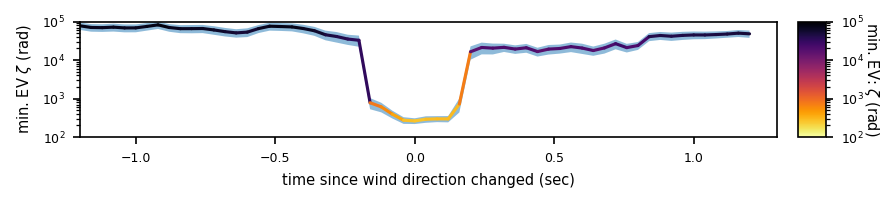

In [151]:
# plot average EV over time since last wind change with std ON plume
subset_df = EV_no_nan_around.copy()
# subset_df['turn_dt'].fillna(0, inplace=True) # try dropping the first nan at the first row. fillna on turn_dt, s.t. there the only nans are the first row of each episode in column step_dt
# subset_df.dropna(inplace=True)                      # NOTE: this is to see if there high observability prior to wind change is due to the first row of each episode - not the case
print(subset_df.head(10))
subset_df = subset_df.groupby('plot_tidx')['zeta'].mean().reset_index()
subset_df['std'] = EV_no_nan_around.groupby('plot_tidx').std().reset_index()['zeta']
subset_df['ste'] = EV_no_nan_around.groupby('plot_tidx').sem().reset_index()['zeta']
subset_df['plot_tidx'] = subset_df['plot_tidx'] * 0.04
states = ['zeta']
n_state = len(states)
import matplotlib.pyplot as plt
import matplotlib as mpl
from pybounds import colorline
fig, ax = plt.subplots(n_state, 1, figsize=(6, n_state*1), dpi=150)
ax = np.atleast_2d(ax)
print(ax.shape)
cmap = 'inferno_r'

max_ev = np.max(subset_df['zeta'].values)
min_ev = np.min(subset_df['zeta'].values)

log_tick_high = int(np.ceil(np.log10(max_ev)))
log_tick_low = int(np.floor(np.log10(min_ev)))
cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

for n, state_name in enumerate(states):
    # colorline(x_sim['x'], x_sim['y'], subset_df[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    colorline(subset_df['plot_tidx'], subset_df[state_name].values, subset_df[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    # add std
    ax[n, 0].fill_between(subset_df['plot_tidx'], subset_df[state_name].values-subset_df['ste'], subset_df[state_name].values+subset_df['ste'], alpha=0.5)
    # Colorbar
    cax = ax[n, -1].inset_axes([1.03, 0.0, 0.04, 1.0])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                        ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    cbar.set_label('min. EV: ' + r'$\zeta$ (rad)', rotation=270, fontsize=7, labelpad=8)
    cbar.ax.tick_params(labelsize=6)

    ax[n, 0].set_ylim(10**log_tick_low, 10**log_tick_high)
    ax[n, 0].set_yscale('log')
    ax[n, 0].set_ylabel('min. EV: ' + state_name, fontsize=7)
    ax[n, 0].set_yticks(np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))


for a in ax.flat:
    a.tick_params(axis='both', labelsize=6)
    
for a in ax[:, 0]:
    a.set_xlabel('time since wind direction changed (sec)', fontsize=7)
    a.set_xlim(subset_df['plot_tidx'].min(), subset_df['plot_tidx'].max() + 0.1)
    # greek letter zeta
    a.set_ylabel(r'min. EV $\zeta$ (rad)', fontsize=7)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)

plt.show()

### plot actions at wind change

In [200]:

manual = EV_no_nan_around.copy()
# manual.dropna(inplace=True)      
manual = manual[manual['plot_tidx'] == 0][['step_dt', 'plot_tidx']]
manual['step_dt'].describe()


# # subset_df['turn_dt'].fillna(0, inplace=True) # try dropping the first nan at the first row. fillna on turn_dt, s.t. there the only nans are the first row of each episode in column step_dt
# subset_df.dropna(inplace=True)                      # NOTE: this is to see if there high observability prior to wind change is due to the first row of each episode - not the case
# # print(subset_df.head(10))
# subset_df = subset_df.groupby('plot_tidx')[['step_dt']].mean().reset_index()
# subset_df[['step_dt', 'plot_tidx']]

count    147.000000
mean       0.032206
std        0.078160
min       -0.101004
25%       -0.003779
50%        0.001281
75%        0.027370
max        0.318733
Name: step_dt, dtype: float64

In [201]:

manual = EV_no_nan_around.copy()
manual.dropna(inplace=True)      
manual = manual[manual['plot_tidx'] == 0][['step_dt', 'plot_tidx']]
manual['step_dt'].describe()


count    122.000000
mean       0.001174
std        0.022666
min       -0.101004
25%       -0.004740
50%       -0.000165
75%        0.004463
max        0.058764
Name: step_dt, dtype: float64

In [196]:

subset_df = EV_no_nan_around.copy()
# subset_df['turn_dt'].fillna(0, inplace=True) # try dropping the first nan at the first row. fillna on turn_dt, s.t. there the only nans are the first row of each episode in column step_dt
subset_df.dropna(inplace=True)                      # NOTE: this is to see if there high observability prior to wind change is due to the first row of each episode - not the case
# print(subset_df.head(10))
subset_df = subset_df.groupby('plot_tidx')[['zeta', 'step', 'turn', 'step_dt', 'turn_dt']].mean().reset_index()
subset_df[['step_dt', 'plot_tidx']][subset_df['plot_tidx'] == 0]

,step_dt,plot_tidx
30,0.001174,0


      time  time_initial    v_para    v_perp         w      zeta  ep_idx  \
7848  0.04          0.00  1.517524  0.393532  0.378834  0.067924      83   
7849  0.08          0.00  1.517524  0.393532  0.378834  0.067924      83   
7850  0.12          0.00  1.517524  0.393532  0.378834  0.067924      83   
7851  0.16          0.00  1.517524  0.393532  0.378834  0.067924      83   
7852  0.20          0.00  1.517524  0.393532  0.378834  0.067924      83   
7853  0.24          0.04  0.976605  0.449078  0.413791  0.100640      83   
7854  0.28          0.08  0.598896  0.354322  0.369932  0.156347      83   
7855  0.32          0.12  0.338711  0.279862  0.360104  0.222575      83   
7856  0.36          0.16  0.178660  0.155852  0.344711  0.411761      83   
7857  0.40          0.20  0.112689  0.049460  0.364565  1.062316      83   

      time_since_last_wind_change  odor_lastenc  odor_01      step      turn  \
7848                         0.00             0        1  0.352573 -0.845863   
784

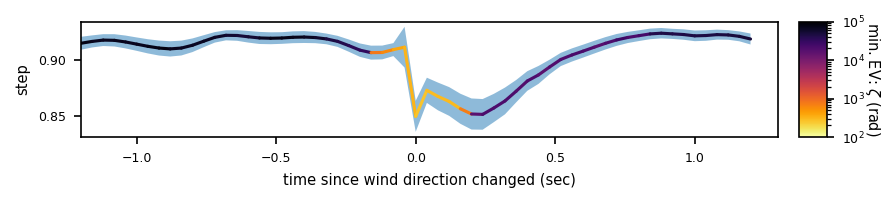

In [202]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from pybounds import colorline

# plot average of actions over time since last wind change
# plot average EV over time since last wind change with std ON plume
subset_df = EV_no_nan_around.copy()
subset_df['turn_dt'].fillna(0, inplace=True) # try dropping the first nan at the first row. fillna on turn_dt, s.t. there the only nans are the first row of each episode in column step_dt
subset_df.dropna(inplace=True)                      # NOTE: this is to see if there high observability prior to wind change is due to the first row of each episode - not the case
print(subset_df.head(10))
subset_df = subset_df.groupby('plot_tidx')[['zeta', 'step', 'turn', 'step_dt', 'turn_dt']].mean().reset_index()
# dispersion std
subset_df['std_zeta'] = EV_no_nan_around.groupby('plot_tidx').std().reset_index()['zeta']
subset_df['std_step'] = EV_no_nan_around.groupby('plot_tidx').std().reset_index()['step']
subset_df['std_step_dt'] = EV_no_nan_around.groupby('plot_tidx').std().reset_index()['step_dt']
subset_df['std_turn'] = EV_no_nan_around.groupby('plot_tidx').std().reset_index()['turn']
subset_df['std_turn_dt'] = EV_no_nan_around.groupby('plot_tidx').std().reset_index()['turn_dt']
# dispersion ste
subset_df['ste_zeta'] = EV_no_nan_around.groupby('plot_tidx').sem().reset_index()['zeta']
subset_df['ste_step'] = EV_no_nan_around.groupby('plot_tidx').sem().reset_index()['step']
subset_df['ste_step_dt'] = EV_no_nan_around.groupby('plot_tidx').sem().reset_index()['step_dt']
subset_df['ste_turn'] = EV_no_nan_around.groupby('plot_tidx').sem().reset_index()['turn']
subset_df['ste_turn_dt'] = EV_no_nan_around.groupby('plot_tidx').sem().reset_index()['turn_dt']
# x-axis
subset_df['plot_tidx'] = subset_df['plot_tidx'] * 0.04
states = ['step']
n_state = len(states)

fig, ax = plt.subplots(n_state, 1, figsize=(6, n_state*1), dpi=150)
ax = np.atleast_2d(ax)
print(ax.shape)
cmap = 'inferno_r'
color_by = 'zeta'

# max, min, log, ticks for the colorbar
max_ev = np.max(subset_df[color_by].values)
min_ev = np.min(subset_df[color_by].values)
log_tick_high = int(np.ceil(np.log10(max_ev)))
log_tick_low = int(np.floor(np.log10(min_ev)))
cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

for n, state_name in enumerate(states):
    dispersion_col = 'ste_' + state_name
    # colorline(x_sim['x'], x_sim['y'], subset_df[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    colorline(subset_df['plot_tidx'], subset_df[state_name].values, subset_df[color_by].values,  # x, y, color 
              ax=ax[n, 0], cmap=cmap, norm=cnorm)
    # add std
    ax[n, 0].fill_between(subset_df['plot_tidx'], 
                          subset_df[state_name].values-subset_df[dispersion_col], 
                          subset_df[state_name].values+subset_df[dispersion_col], 
                          alpha=0.5)
    # Colorbar
    cax = ax[n, -1].inset_axes([1.03, 0.0, 0.04, 1.0])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                        ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    cbar.set_label('min. EV: ' + r'$\zeta$ (rad)', rotation=270, fontsize=7, labelpad=8)
    cbar.ax.tick_params(labelsize=6)

    # set y label
    # ax[n, 0].set_ylim(10**log_tick_low, 10**log_tick_high)
    # ax[n, 0].set_yscale('log')
    ax[n, 0].set_ylabel(state_name, fontsize=7)
    # ax[n, 0].set_yticks(np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))


for a in ax.flat:
    a.tick_params(axis='both', labelsize=6)
    
for a in ax[:, 0]:
    a.set_xlabel('time since wind direction changed (sec)', fontsize=7)
    a.set_xlim(subset_df['plot_tidx'].min(), subset_df['plot_tidx'].max() + 0.1)
    # greek letter zeta
    a.set_ylabel(state_name, fontsize=7)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)

plt.show()

   plot_tidx          zeta      step      turn   step_dt   turn_dt
0        -30  77702.067943  0.914924 -0.166145  0.001115  0.000703
1        -29  70364.753302  0.916567 -0.160829  0.001642  0.000893
2        -28  69552.873656  0.917762 -0.156615  0.001195  0.000881
3        -27  71659.499224  0.917547 -0.152275 -0.000215  0.000793
4        -26  68483.339279  0.916081 -0.154740 -0.001467  0.000826
5        -25  68599.867115  0.914143 -0.163011 -0.001938  0.000881
6        -24  74900.659910  0.912191 -0.173391 -0.001952  0.000821
7        -23  82198.837469  0.910639 -0.182563 -0.001552  0.000798
8        -22  70146.835750  0.909891 -0.187158 -0.000749  0.000726
9        -21  65439.200343  0.910637 -0.185274  0.000747  0.000664
(4, 1)


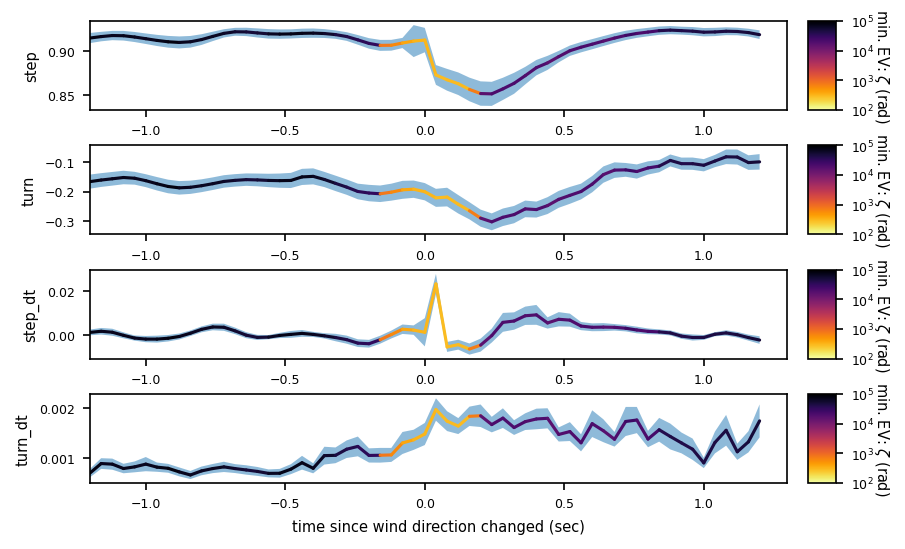

In [160]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from pybounds import colorline

# plot average of actions over time since last wind change
# plot average EV over time since last wind change with std ON plume
subset_df = EV_no_nan_around.copy()
# subset_df['turn_dt'].fillna(0, inplace=True) # try dropping the first nan at the first row. fillna on turn_dt, s.t. there the only nans are the first row of each episode in column step_dt
subset_df.dropna(inplace=True)                      # NOTE: this is to see if there high observability prior to wind change is due to the first row of each episode - not the case
subset_df = subset_df.groupby('plot_tidx')[['zeta', 'step', 'turn', 'step_dt', 'turn_dt']].mean().reset_index()
print(subset_df.head(10))
# dispersion std
subset_df['std_zeta'] = EV_no_nan_around.groupby('plot_tidx').std().reset_index()['zeta']
subset_df['std_step'] = EV_no_nan_around.groupby('plot_tidx').std().reset_index()['step']
subset_df['std_step_dt'] = EV_no_nan_around.groupby('plot_tidx').std().reset_index()['step_dt']
subset_df['std_turn'] = EV_no_nan_around.groupby('plot_tidx').std().reset_index()['turn']
subset_df['std_turn_dt'] = EV_no_nan_around.groupby('plot_tidx').std().reset_index()['turn_dt']
# dispersion ste
subset_df['ste_zeta'] = EV_no_nan_around.groupby('plot_tidx').sem().reset_index()['zeta']
subset_df['ste_step'] = EV_no_nan_around.groupby('plot_tidx').sem().reset_index()['step']
subset_df['ste_step_dt'] = EV_no_nan_around.groupby('plot_tidx').sem().reset_index()['step_dt']
subset_df['ste_turn'] = EV_no_nan_around.groupby('plot_tidx').sem().reset_index()['turn']
subset_df['ste_turn_dt'] = EV_no_nan_around.groupby('plot_tidx').sem().reset_index()['turn_dt']
# x-axis
subset_df['plot_tidx'] = subset_df['plot_tidx'] * 0.04
states = ['step', 'turn', 'step_dt', 'turn_dt']
n_state = len(states)

fig, ax = plt.subplots(n_state, 1, figsize=(6, n_state*1), dpi=150)
ax = np.atleast_2d(ax)
ax = ax.reshape(-1, 1)
print(ax.shape)
cmap = 'inferno_r'
color_by = 'zeta'

# max, min, log, ticks for the colorbar
max_ev = np.max(subset_df[color_by].values)
min_ev = np.min(subset_df[color_by].values)
log_tick_high = int(np.ceil(np.log10(max_ev)))
log_tick_low = int(np.floor(np.log10(min_ev)))
cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

for n, state_name in enumerate(states):
    dispersion_col = 'ste_' + state_name
    # colorline(x_sim['x'], x_sim['y'], subset_df[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    colorline(subset_df['plot_tidx'], subset_df[state_name].values, subset_df[color_by].values,  # x, y, color 
              ax=ax[n, 0], cmap=cmap, norm=cnorm)
    # add std
    ax[n, 0].fill_between(subset_df['plot_tidx'], 
                          subset_df[state_name].values-subset_df[dispersion_col], 
                          subset_df[state_name].values+subset_df[dispersion_col], 
                          alpha=0.5)
    # Colorbar
    cax = ax[n, -1].inset_axes([1.03, 0.0, 0.04, 1.0])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                        ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    cbar.set_label('min. EV: ' + r'$\zeta$ (rad)', rotation=270, fontsize=7, labelpad=8)
    cbar.ax.tick_params(labelsize=6)

    # set y label
    # ax[n, 0].set_ylim(10**log_tick_low, 10**log_tick_high)
    # ax[n, 0].set_yscale('log')
    ax[n, 0].set_ylabel(state_name, fontsize=7)
    # ax[n, 0].set_yticks(np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))


for a in ax.flat:
    a.tick_params(axis='both', labelsize=6)
    
for a in ax[:, 0]:
    a.set_xlabel('time since wind direction changed (sec)', fontsize=7)
    a.set_xlim(subset_df['plot_tidx'].min(), subset_df['plot_tidx'].max() + 0.1)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)

plt.show()

do nor drop the second NAN

(2, 1)


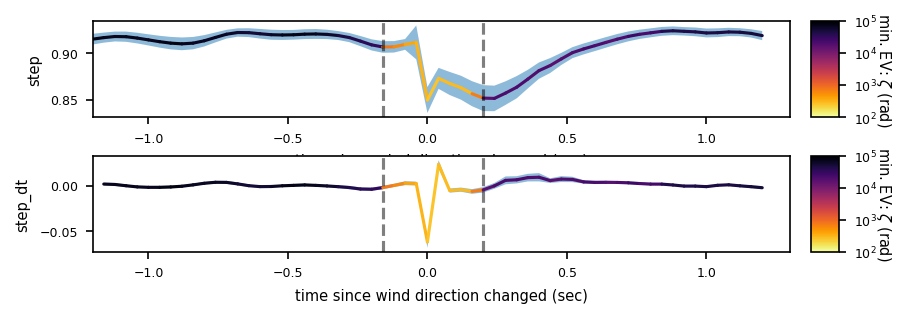

In [211]:
# plot average of actions over time since last wind change
# plot average EV over time since last wind change with std ON plume
subset_df = EV_no_nan_around.copy()
subset_df['turn_dt'].fillna(0, inplace=True) # try dropping the first nan at the first row. fillna on turn_dt, s.t. there the only nans are the first row of each episode in column step_dt
subset_df.dropna(inplace=True)                      # NOTE: this is to see if there high observability prior to wind change is due to the first row of each episode - not the case
# print(subset_df.head(10))
# subset_df.head(10)
subset_df = subset_df.groupby('plot_tidx')[['zeta', 'step']].mean().reset_index()
subset_df['step_dt'] = subset_df['step'].diff()

# dispersion std
subset_df['std_zeta'] = EV_no_nan_around.groupby('plot_tidx').std().reset_index()['zeta']
subset_df['std_step'] = EV_no_nan_around.groupby('plot_tidx').std().reset_index()['step']
subset_df['std_step_dt'] = EV_no_nan_around.groupby('plot_tidx').std().reset_index()['step_dt']
# subset_df['std_turn'] = EV_no_nan_around.groupby('plot_tidx').std().reset_index()['turn']
# subset_df['std_turn_dt'] = EV_no_nan_around.groupby('plot_tidx').std().reset_index()['turn_dt']
# dispersion ste
subset_df['ste_zeta'] = EV_no_nan_around.groupby('plot_tidx').sem().reset_index()['zeta']
subset_df['ste_step'] = EV_no_nan_around.groupby('plot_tidx').sem().reset_index()['step']
subset_df['ste_step_dt'] = EV_no_nan_around.groupby('plot_tidx').sem().reset_index()['step_dt']
# subset_df['ste_turn'] = EV_no_nan_around.groupby('plot_tidx').sem().reset_index()['turn']
# subset_df['ste_turn_dt'] = EV_no_nan_around.groupby('plot_tidx').sem().reset_index()['turn_dt']
# x-axis
subset_df['plot_tidx'] = subset_df['plot_tidx'] * 0.04
states = ['step', 'step_dt']
# states = ['step', 'turn', 'step_dt', 'turn_dt']
n_state = len(states)

fig, ax = plt.subplots(n_state, 1, figsize=(6, n_state*1), dpi=150)
ax = np.atleast_2d(ax)
ax = ax.reshape(-1, 1)
print(ax.shape)
cmap = 'inferno_r'
color_by = 'zeta'

# max, min, log, ticks for the colorbar
max_ev = np.max(subset_df[color_by].values)
min_ev = np.min(subset_df[color_by].values)
log_tick_high = int(np.ceil(np.log10(max_ev)))
log_tick_low = int(np.floor(np.log10(min_ev)))
cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

for n, state_name in enumerate(states):
    dispersion_col = 'ste_' + state_name
    # colorline(x_sim['x'], x_sim['y'], subset_df[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    colorline(subset_df['plot_tidx'], subset_df[state_name].values, subset_df[color_by].values,  # x, y, color 
              ax=ax[n, 0], cmap=cmap, norm=cnorm)
    # add std
    ax[n, 0].fill_between(subset_df['plot_tidx'], 
                          subset_df[state_name].values-subset_df[dispersion_col], 
                          subset_df[state_name].values+subset_df[dispersion_col], 
                          alpha=0.5)
    # Colorbar
    cax = ax[n, -1].inset_axes([1.03, 0.0, 0.04, 1.0])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                        ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    cbar.set_label('min. EV: ' + r'$\zeta$ (rad)', rotation=270, fontsize=7, labelpad=8)
    cbar.ax.tick_params(labelsize=6)

    # set y label
    # ax[n, 0].set_ylim(10**log_tick_low, 10**log_tick_high)
    # ax[n, 0].set_yscale('log')
    ax[n, 0].set_ylabel(state_name, fontsize=7)
    # ax[n, 0].set_yticks(np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))


for a in ax.flat:
    a.tick_params(axis='both', labelsize=6)
    
for a in ax[:, 0]:
    a.set_xlabel('time since wind direction changed (sec)', fontsize=7)
    a.set_xlim(subset_df['plot_tidx'].min(), subset_df['plot_tidx'].max() + 0.1)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)
# plot vertical lines
for a in ax.flat:
    a.axvline(0.2, color='k', linestyle='--', alpha=0.5)
    a.axvline(-0.16, color='k', linestyle='--', alpha=0.5)

plt.show()

(4, 1)


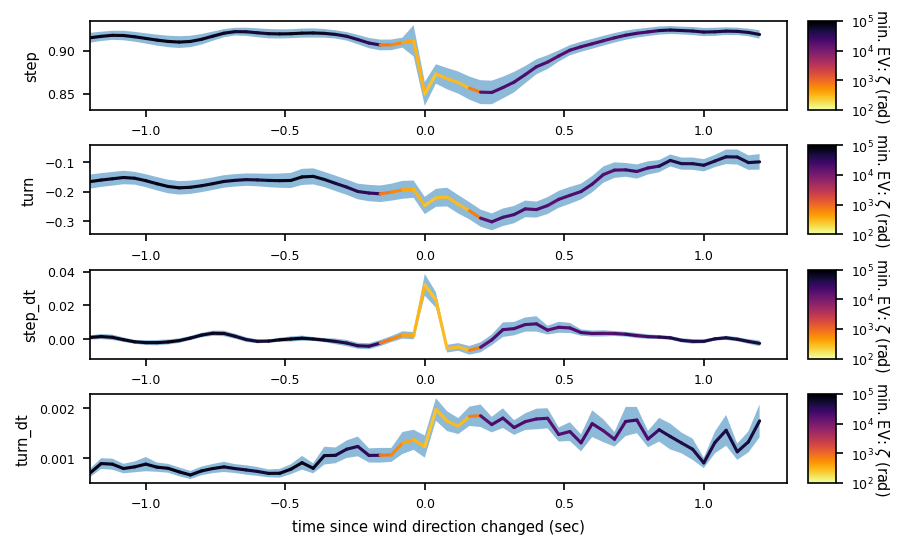

In [203]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from pybounds import colorline

# plot average of actions over time since last wind change
# plot average EV over time since last wind change with std ON plume
subset_df = EV_no_nan_around.copy()
subset_df['turn_dt'].fillna(0, inplace=True) # try dropping the first nan at the first row. fillna on turn_dt, s.t. there the only nans are the first row of each episode in column step_dt
subset_df.dropna(inplace=True)                      # NOTE: this is to see if there high observability prior to wind change is due to the first row of each episode - not the case
# print(subset_df.head(10))
subset_df.head(10)
subset_df = subset_df.groupby('plot_tidx')[['zeta', 'step', 'turn', 'step_dt', 'turn_dt']].mean().reset_index()
# dispersion std
subset_df['std_zeta'] = EV_no_nan_around.groupby('plot_tidx').std().reset_index()['zeta']
subset_df['std_step'] = EV_no_nan_around.groupby('plot_tidx').std().reset_index()['step']
subset_df['std_step_dt'] = EV_no_nan_around.groupby('plot_tidx').std().reset_index()['step_dt']
subset_df['std_turn'] = EV_no_nan_around.groupby('plot_tidx').std().reset_index()['turn']
subset_df['std_turn_dt'] = EV_no_nan_around.groupby('plot_tidx').std().reset_index()['turn_dt']
# dispersion ste
subset_df['ste_zeta'] = EV_no_nan_around.groupby('plot_tidx').sem().reset_index()['zeta']
subset_df['ste_step'] = EV_no_nan_around.groupby('plot_tidx').sem().reset_index()['step']
subset_df['ste_step_dt'] = EV_no_nan_around.groupby('plot_tidx').sem().reset_index()['step_dt']
subset_df['ste_turn'] = EV_no_nan_around.groupby('plot_tidx').sem().reset_index()['turn']
subset_df['ste_turn_dt'] = EV_no_nan_around.groupby('plot_tidx').sem().reset_index()['turn_dt']
# x-axis
subset_df['plot_tidx'] = subset_df['plot_tidx'] * 0.04
states = ['step', 'turn', 'step_dt', 'turn_dt']
n_state = len(states)

fig, ax = plt.subplots(n_state, 1, figsize=(6, n_state*1), dpi=150)
ax = np.atleast_2d(ax)
ax = ax.reshape(-1, 1)
print(ax.shape)
cmap = 'inferno_r'
color_by = 'zeta'

# max, min, log, ticks for the colorbar
max_ev = np.max(subset_df[color_by].values)
min_ev = np.min(subset_df[color_by].values)
log_tick_high = int(np.ceil(np.log10(max_ev)))
log_tick_low = int(np.floor(np.log10(min_ev)))
cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

for n, state_name in enumerate(states):
    dispersion_col = 'ste_' + state_name
    # colorline(x_sim['x'], x_sim['y'], subset_df[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    colorline(subset_df['plot_tidx'], subset_df[state_name].values, subset_df[color_by].values,  # x, y, color 
              ax=ax[n, 0], cmap=cmap, norm=cnorm)
    # add std
    ax[n, 0].fill_between(subset_df['plot_tidx'], 
                          subset_df[state_name].values-subset_df[dispersion_col], 
                          subset_df[state_name].values+subset_df[dispersion_col], 
                          alpha=0.5)
    # Colorbar
    cax = ax[n, -1].inset_axes([1.03, 0.0, 0.04, 1.0])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                        ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    cbar.set_label('min. EV: ' + r'$\zeta$ (rad)', rotation=270, fontsize=7, labelpad=8)
    cbar.ax.tick_params(labelsize=6)

    # set y label
    # ax[n, 0].set_ylim(10**log_tick_low, 10**log_tick_high)
    # ax[n, 0].set_yscale('log')
    ax[n, 0].set_ylabel(state_name, fontsize=7)
    # ax[n, 0].set_yticks(np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))


for a in ax.flat:
    a.tick_params(axis='both', labelsize=6)
    
for a in ax[:, 0]:
    a.set_xlabel('time since wind direction changed (sec)', fontsize=7)
    a.set_xlim(subset_df['plot_tidx'].min(), subset_df['plot_tidx'].max() + 0.1)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)

plt.show()

do not drop 2nd NAN and plot median

(4, 1)


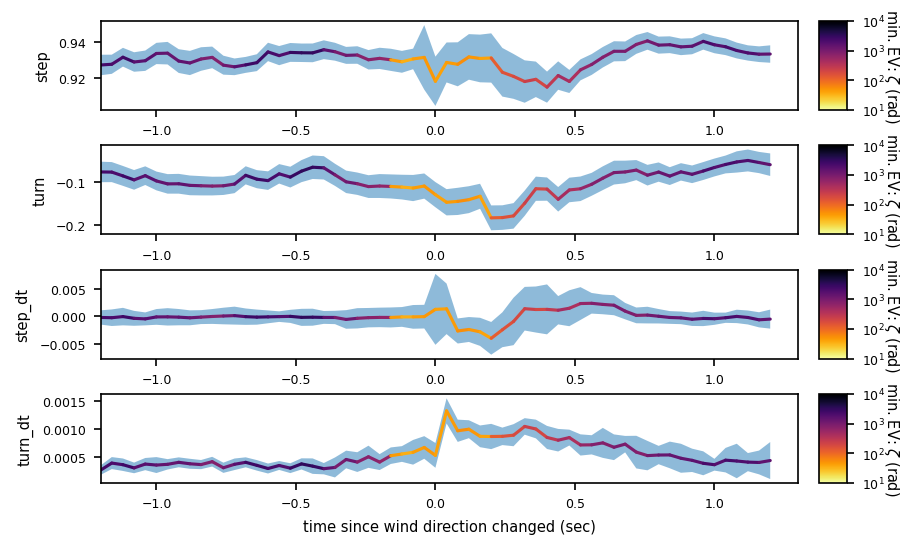

In [161]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from pybounds import colorline

# plot average of actions over time since last wind change
# plot average EV over time since last wind change with std ON plume
subset_df = EV_no_nan_around.copy()
subset_df['turn_dt'].fillna(0, inplace=True) # try dropping the first nan at the first row. fillna on turn_dt, s.t. there the only nans are the first row of each episode in column step_dt
subset_df.dropna(inplace=True)                      # NOTE: this is to see if there high observability prior to wind change is due to the first row of each episode - not the case
# print(subset_df.head(10))
subset_df.head(10)
subset_df = subset_df.groupby('plot_tidx')[['zeta', 'step', 'turn', 'step_dt', 'turn_dt']].median().reset_index()
# dispersion std
subset_df['std_zeta'] = EV_no_nan_around.groupby('plot_tidx').std().reset_index()['zeta']
subset_df['std_step'] = EV_no_nan_around.groupby('plot_tidx').std().reset_index()['step']
subset_df['std_step_dt'] = EV_no_nan_around.groupby('plot_tidx').std().reset_index()['step_dt']
subset_df['std_turn'] = EV_no_nan_around.groupby('plot_tidx').std().reset_index()['turn']
subset_df['std_turn_dt'] = EV_no_nan_around.groupby('plot_tidx').std().reset_index()['turn_dt']
# dispersion ste
subset_df['ste_zeta'] = EV_no_nan_around.groupby('plot_tidx').sem().reset_index()['zeta']
subset_df['ste_step'] = EV_no_nan_around.groupby('plot_tidx').sem().reset_index()['step']
subset_df['ste_step_dt'] = EV_no_nan_around.groupby('plot_tidx').sem().reset_index()['step_dt']
subset_df['ste_turn'] = EV_no_nan_around.groupby('plot_tidx').sem().reset_index()['turn']
subset_df['ste_turn_dt'] = EV_no_nan_around.groupby('plot_tidx').sem().reset_index()['turn_dt']
# x-axis
subset_df['plot_tidx'] = subset_df['plot_tidx'] * 0.04
states = ['step', 'turn', 'step_dt', 'turn_dt']
n_state = len(states)

fig, ax = plt.subplots(n_state, 1, figsize=(6, n_state*1), dpi=150)
ax = np.atleast_2d(ax)
ax = ax.reshape(-1, 1)
print(ax.shape)
cmap = 'inferno_r'
color_by = 'zeta'

# max, min, log, ticks for the colorbar
max_ev = np.max(subset_df[color_by].values)
min_ev = np.min(subset_df[color_by].values)
log_tick_high = int(np.ceil(np.log10(max_ev)))
log_tick_low = int(np.floor(np.log10(min_ev)))
cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

for n, state_name in enumerate(states):
    dispersion_col = 'ste_' + state_name
    # colorline(x_sim['x'], x_sim['y'], subset_df[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    colorline(subset_df['plot_tidx'], subset_df[state_name].values, subset_df[color_by].values,  # x, y, color 
              ax=ax[n, 0], cmap=cmap, norm=cnorm)
    # add std
    ax[n, 0].fill_between(subset_df['plot_tidx'], 
                          subset_df[state_name].values-subset_df[dispersion_col], 
                          subset_df[state_name].values+subset_df[dispersion_col], 
                          alpha=0.5)
    # Colorbar
    cax = ax[n, -1].inset_axes([1.03, 0.0, 0.04, 1.0])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                        ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    cbar.set_label('min. EV: ' + r'$\zeta$ (rad)', rotation=270, fontsize=7, labelpad=8)
    cbar.ax.tick_params(labelsize=6)

    # set y label
    # ax[n, 0].set_ylim(10**log_tick_low, 10**log_tick_high)
    # ax[n, 0].set_yscale('log')
    ax[n, 0].set_ylabel(state_name, fontsize=7)
    # ax[n, 0].set_yticks(np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))


for a in ax.flat:
    a.tick_params(axis='both', labelsize=6)
    
for a in ax[:, 0]:
    a.set_xlabel('time since wind direction changed (sec)', fontsize=7)
    a.set_xlim(subset_df['plot_tidx'].min(), subset_df['plot_tidx'].max() + 0.1)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)

plt.show()

### distr. of actions

In [66]:
subset_df = EV_no_nan_around.copy()
subset_df = subset_df[subset_df['plot_tidx'] < 5]
subset_df = subset_df[subset_df['plot_tidx'] > -5]
subset_df.head(10)

,time,time_initial,v_para,v_perp,w,zeta,ep_idx,time_since_last_wind_change,odor_lastenc,odor_01,step,turn,step_dt,turn_dt,plot_tidx
7847,0.00,0.00,1.517524,0.393532,0.378834,0.067924,83,0.04,0,1,0.243873,-0.806738,NaN,NaN,-1
7848,0.04,0.00,1.517524,0.393532,0.378834,0.067924,83,0.00,0,1,0.352573,-0.845863,0.108700,NaN,0
7849,0.08,0.00,1.517524,0.393532,0.378834,0.067924,83,0.04,0,1,0.449508,-0.769184,0.096935,0.001597,1
7850,0.12,0.00,1.517524,0.393532,0.378834,0.067924,83,0.08,0,1,0.395366,-0.754988,-0.054142,0.000296,2
7851,0.16,0.00,1.517524,0.393532,0.378834,0.067924,83,0.12,0,1,0.372357,-0.785812,-0.023009,0.000642,3
7852,0.20,0.00,1.517524,0.393532,0.378834,0.067924,83,0.16,0,1,0.355679,-0.804831,-0.016678,0.000396,4
7920,2.92,2.72,26942.107210,932.618094,3542.383152,19.711145,83,2.88,52,0,0.962487,-0.055763,0.000209,0.000154,-4
7921,2.96,2.76,79481.906289,2238.520575,9858.301394,20.656272,83,2.92,53,0,0.961910,-0.049383,-0.000576,0.000133,-3
7922,3.00,2.80,138418.491814,3386.565583,16360.372075,19.601239,83,2.96,54,0,0.961031,-0.048126,-0.000880,0.000026,-2
7923,3.04,2.84,60308.626553,1321.262768,6904.533246,34.253610,83,3.00,55,0,0.960232,-0.050413,-0.000799,0.000048,-1


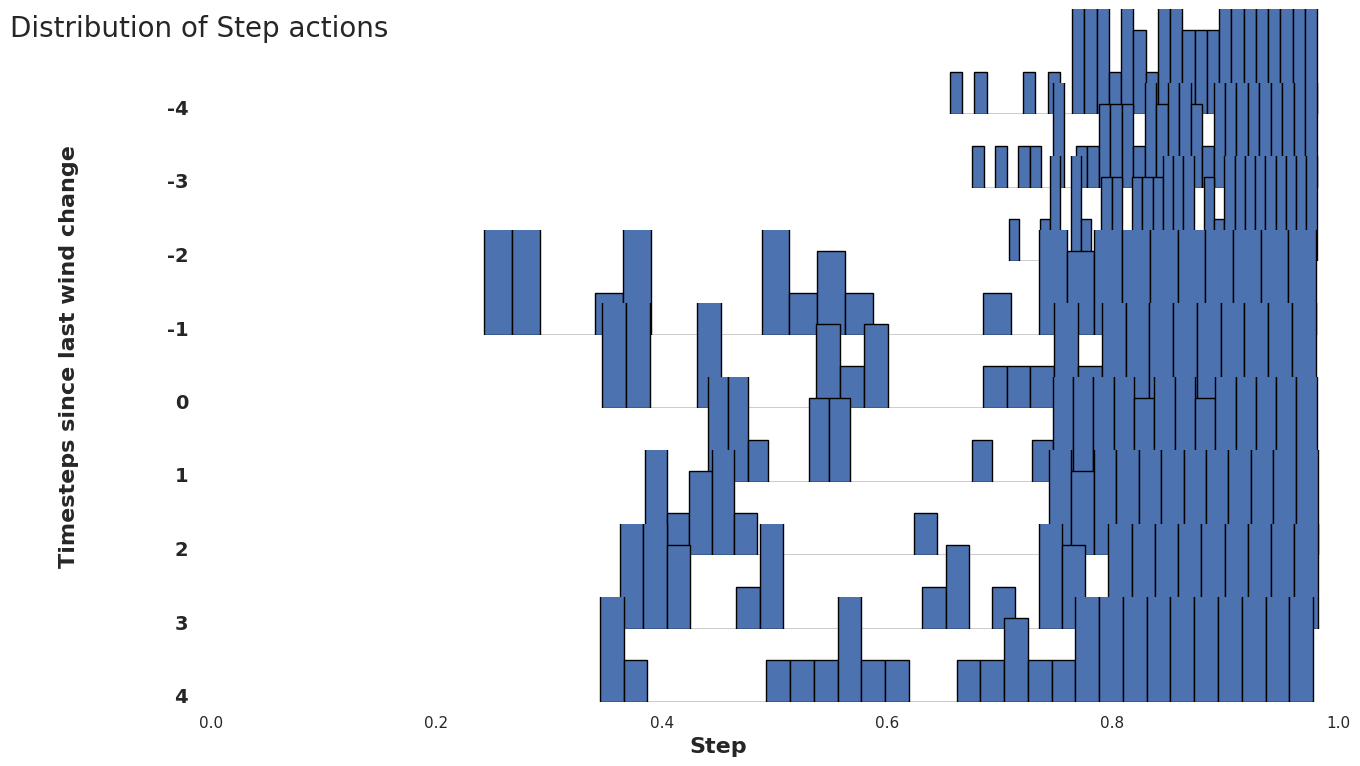

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec
from sklearn.neighbors import KernelDensity
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# create df
subset_df = EV_no_nan_around.copy()
subset_df = subset_df[subset_df['plot_tidx'] < 5]
subset_df = subset_df[subset_df['plot_tidx'] > -5]


countries = [x for x in np.unique(subset_df['plot_tidx'])]

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
color_by = 'zeta'
color_values = subset_df[color_by]  # Replace 'your_continuous_column' with the actual column name
# Create a colormap and normalize the color variable
cmap = plt.get_cmap('inferno_r')  # Choose a colormap (e.g., 'viridis', 'plasma', 'coolwarm')
norm = Normalize(vmin=color_values.min(), vmax=color_values.max())  # Normalize the color variable

# max, min, log, ticks for the colorbar
max_ev = np.max(subset_df[color_by].values)
min_ev = np.min(subset_df[color_by].values)
log_tick_high = int(np.ceil(np.log10(max_ev)))
log_tick_low = int(np.floor(np.log10(min_ev)))
cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)


gs = grid_spec.GridSpec(len(countries),1)
fig = plt.figure(figsize=(16,9))

i = 0

ax_objs = []
for plot_tidx in countries:
    country = countries[i]
    x = np.array(subset_df[subset_df['plot_tidx'] == plot_tidx].step)
    color_value = subset_df[subset_df['plot_tidx'] == plot_tidx][color_by].mean()  # Use mean or another aggregation for the group

    # creating new axes object
    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

    
    # plotting the distribution
    # x_d = np.linspace(0,1, 1000)
    # kde = KernelDensity(bandwidth=0.03, kernel='gaussian')
    # kde.fit(x[:, None])
    # logprob = kde.score_samples(x_d[:, None], )
    # ax_objs[-1].plot(x_d, np.exp(logprob),color="#f0f0f0",lw=1)
    # ax_objs[-1].fill_between(x_d, np.exp(logprob), alpha=1) #,color=colors[i])

    # plotting the histogram 
    ax_objs[-1].hist(x, bins=30, alpha=1, edgecolor="black") #, color=cmap(cnorm(color_value)))

    # setting uniform x and y lims
    ax_objs[-1].set_xlim(-0.1,1)
    ax_objs[-1].set_ylim(0,2.5)

    # make background transparent
    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    # remove borders, axis ticks, and labels
    ax_objs[-1].set_yticklabels([])

    if not plot_tidx:
        ax_objs[-1].set_ylabel("Timesteps since last wind change", fontsize=16,fontweight="bold")
        ax_objs[-1].yaxis.label.set_rotation(90)
    if i == len(countries)-1:
        ax_objs[-1].set_xlabel("Step", fontsize=16,fontweight="bold")
    else:
        ax_objs[-1].set_xticklabels([])

    spines = ["top","right","left","bottom"]
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)

    # adj_country = country.replace(" ","\n")
    ax_objs[-1].text(-0.02,0,plot_tidx,fontweight="bold",fontsize=14,ha="right")


    i += 1

gs.update(hspace=-0.3)

fig.text(0.07,0.85,"Distribution of Step actions",fontsize=20)

plt.tight_layout()
plt.show()

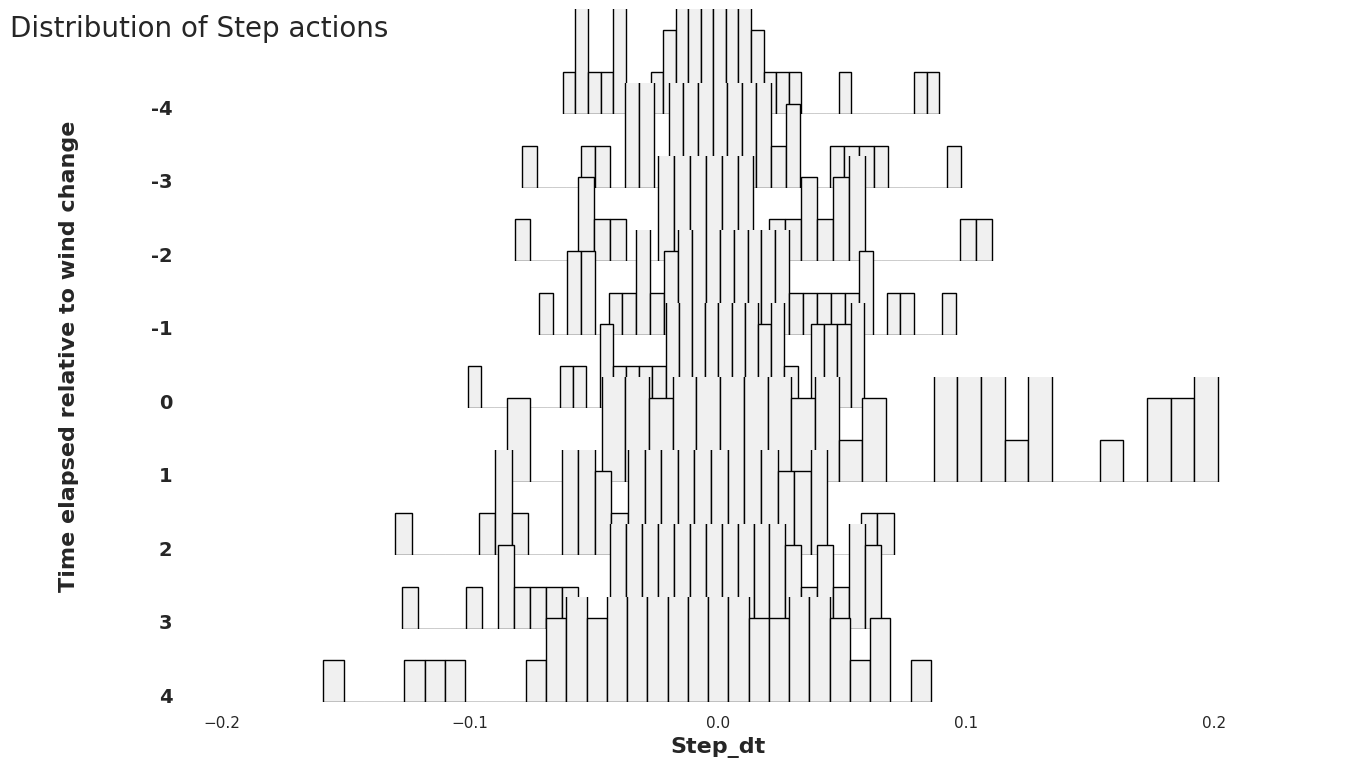

In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec
from sklearn.neighbors import KernelDensity
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# create df
subset_df = EV_no_nan_around.copy()
subset_df = subset_df[subset_df['plot_tidx'] < 5]
subset_df = subset_df[subset_df['plot_tidx'] > -5]
subset_df.dropna(inplace=True)
countries = [x for x in np.unique(subset_df['plot_tidx'])]
# colors = ['#0000ff', '#3300cc', '#660099', '#990066', '#cc0033', '#ff0000']

gs = grid_spec.GridSpec(len(countries),1)
fig = plt.figure(figsize=(16,9))

i = 0

ax_objs = []
for plot_tidx in countries:
    country = countries[i]
    x = np.array(subset_df[subset_df['plot_tidx'] == plot_tidx].step_dt)
    x_d = np.linspace(0,1, 1000)

    kde = KernelDensity(bandwidth=0.03, kernel='gaussian')
    kde.fit(x[:, None])

    logprob = kde.score_samples(x_d[:, None], )

    # creating new axes object
    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

    # plotting the distribution
    # ax_objs[-1].plot(x_d, np.exp(logprob),color="#f0f0f0",lw=1)
    # ax_objs[-1].fill_between(x_d, np.exp(logprob), alpha=1) #,color=colors[i])

    # plotting the histogram
    ax_objs[-1].hist(x, bins=30, color="#f0f0f0", alpha=1, edgecolor="black")

    # setting uniform x and y lims
    ax_objs[-1].set_xlim(-0.25,0.25)
    ax_objs[-1].set_ylim(0,2.5)

    # make background transparent
    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    # remove borders, axis ticks, and labels
    ax_objs[-1].set_yticklabels([])

    if not plot_tidx:
        ax_objs[-1].set_ylabel("Time elapsed relative to wind change", fontsize=16,fontweight="bold")
        # rotate y label to vertical
        ax_objs[-1].yaxis.label.set_rotation(90)

    if i == len(countries)-1:
        ax_objs[-1].set_xlabel("Step_dt", fontsize=16,fontweight="bold")

    else:
        ax_objs[-1].set_xticklabels([])

    spines = ["top","right","left","bottom"]
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)

    # adj_country = country.replace(" ","\n")
    ax_objs[-1].text(-0.22,0,plot_tidx,fontweight="bold",fontsize=14,ha="right")


    i += 1

gs.update(hspace=-0.3)

fig.text(0.07,0.85,"Distribution of Step actions",fontsize=20)

plt.tight_layout()
plt.show()

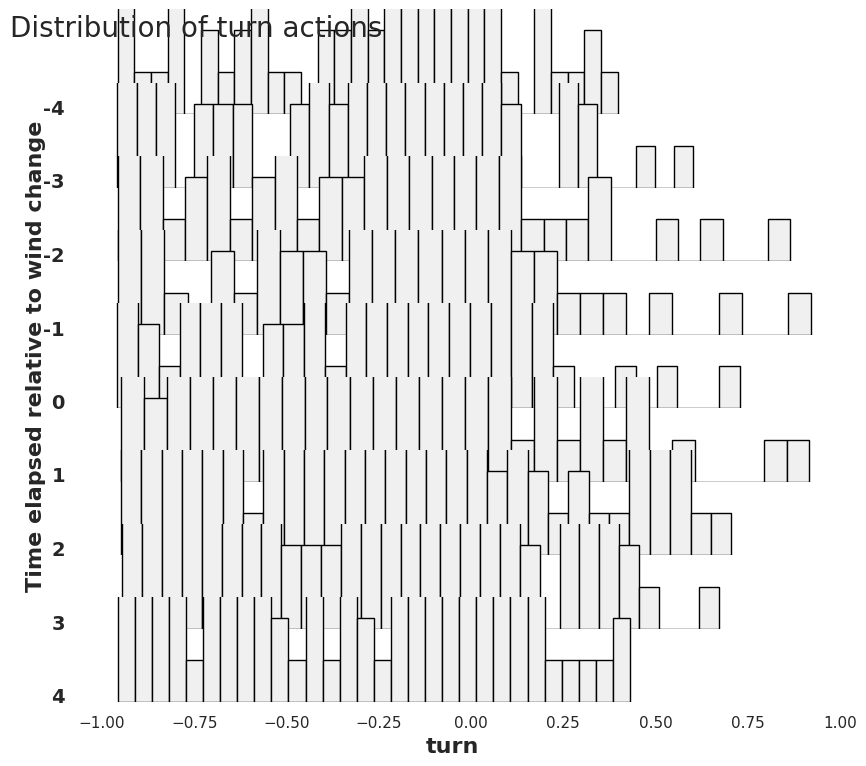

In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec
from sklearn.neighbors import KernelDensity
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# create df
subset_df = EV_no_nan_around.copy()
subset_df = subset_df[subset_df['plot_tidx'] < 5]
subset_df = subset_df[subset_df['plot_tidx'] > -5]
subset_df.dropna(inplace=True)
countries = [x for x in np.unique(subset_df['plot_tidx'])]
# colors = ['#0000ff', '#3300cc', '#660099', '#990066', '#cc0033', '#ff0000']

gs = grid_spec.GridSpec(len(countries),1)
fig = plt.figure(figsize=(10,9))

i = 0

ax_objs = []
for plot_tidx in countries:
    country = countries[i]
    x = np.array(subset_df[subset_df['plot_tidx'] == plot_tidx].turn)
    # creating new axes object
    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

    # plotting the distribution
    # x_d = np.linspace(0,1, 1000)
    # kde = KernelDensity(bandwidth=0.03, kernel='gaussian')
    # kde.fit(x[:, None])
    # logprob = kde.score_samples(x_d[:, None], )
    # ax_objs[-1].plot(x_d, np.exp(logprob),color="#f0f0f0",lw=1)
    # ax_objs[-1].fill_between(x_d, np.exp(logprob), alpha=1) #,color=colors[i])

    # plotting the histogram
    ax_objs[-1].hist(x, bins=30, color="#f0f0f0", alpha=1, edgecolor="black")

    # setting uniform x and y lims
    ax_objs[-1].set_xlim(-1.1,1)
    ax_objs[-1].set_ylim(0,2.5)

    # make background transparent
    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    # remove borders, axis ticks, and labels
    ax_objs[-1].set_yticklabels([])

    if not plot_tidx:
        ax_objs[-1].set_ylabel("Time elapsed relative to wind change", fontsize=16,fontweight="bold")
        # rotate y label to vertical
        ax_objs[-1].yaxis.label.set_rotation(90)

    if i == len(countries)-1:
        ax_objs[-1].set_xlabel("turn", fontsize=16,fontweight="bold")

    else:
        ax_objs[-1].set_xticklabels([])

    spines = ["top","right","left","bottom"]
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)

    # adj_country = country.replace(" ","\n")
    ax_objs[-1].text(-1.1,0,plot_tidx,fontweight="bold",fontsize=14,ha="right")


    i += 1

gs.update(hspace=-0.3)

fig.text(0.07,0.85,"Distribution of turn actions",fontsize=20)

plt.tight_layout()
plt.show()

## plot at odor contact duration

## add odor contact duration

In [10]:
# time since last encounter
def _count_lenc(lenc0, maxcount=None):
    count = 0
    lenc = []
    for i in range(len(lenc0)):
        count = 0 if lenc0[i] == 0 else count+1
        # print(i, lenc0[i], count)
        if maxcount is not None:
            count = maxcount if count >= maxcount else count
        lenc.append(count)
    return lenc
# traj_df['odor_lastenc'] = _count_lenc( 1 - traj_df['odor_01'], maxcount=15 )
EV_no_nan['odor_01_duration'] = _count_lenc(EV_no_nan['odor_01'], maxcount=None )
EV_no_nan['odor_01_duration'] = EV_no_nan['odor_01_duration'] * 0.04 # 0.04s per step
#  _count_lenc(EV_no_nan[EV_no_nan['ep_idx'] == 160]['odor_01'], maxcount=None )

EV_no_nan[EV_no_nan['ep_idx'] == 118].tail(10)


,time,time_initial,v_para,v_perp,w,zeta,ep_idx,time_since_last_wind_change,odor_01,odor_01_duration
10598,9.56,9.36,35687.919703,3897.941326,10035.427041,176.570751,118,1.60,0,0.0
10599,9.60,9.40,25143.457939,2684.373816,5919.285126,140.030158,118,1.64,0,0.0
10600,9.64,9.44,25889.372706,2658.341906,4694.329494,483.085158,118,1.68,0,0.0
10601,9.68,9.48,38802.462598,3767.057231,5185.664215,1915.114778,118,1.72,0,0.0
10602,9.72,9.52,88620.581822,8009.111298,9030.252025,7903.002416,118,1.76,0,0.0
10603,9.76,9.56,304591.794736,25314.063747,26568.138480,36437.921930,118,1.80,0,0.0
10604,9.80,9.56,304591.794736,25314.063747,26568.138480,36437.921930,118,1.84,0,0.0
10605,9.84,9.56,304591.794736,25314.063747,26568.138480,36437.921930,118,1.88,0,0.0
10606,9.88,9.56,304591.794736,25314.063747,26568.138480,36437.921930,118,1.92,0,0.0
10607,9.92,9.56,304591.794736,25314.063747,26568.138480,36437.921930,118,1.96,0,0.0


## plot around odor contact

   odor_01_duration          zeta
0              0.00  34557.908921
1              0.04  12523.017930
2              0.08  15295.649045
3              0.12   8536.240643
4              0.16   7033.873657
5              0.20   6375.206414
6              0.24   5636.589777
7              0.28   4458.706149
8              0.32   3556.486060
9              0.36   2893.655158
(1, 1)


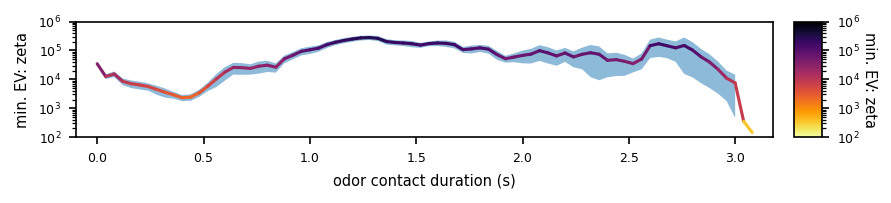

In [9]:
# plot average EV over time since last wind change with std ON plume
subset_df = EV_no_nan
subset_df = subset_df.groupby('odor_01_duration')['zeta'].mean().reset_index()
print(subset_df.head(10))
subset_df['std'] = EV_no_nan.groupby('odor_01_duration').std().reset_index()['zeta']
subset_df['ste'] = EV_no_nan.groupby('odor_01_duration').sem().reset_index()['zeta']
states = ['zeta']
n_state = len(states)
import matplotlib.pyplot as plt
import matplotlib as mpl
from pybounds import colorline
fig, ax = plt.subplots(n_state, 1, figsize=(6, n_state*1), dpi=150)
ax = np.atleast_2d(ax)
print(ax.shape)
cmap = 'inferno_r'

max_ev = np.max(subset_df['zeta'].values)
min_ev = np.min(subset_df['zeta'].values)

log_tick_high = int(np.ceil(np.log10(max_ev)))
log_tick_low = int(np.floor(np.log10(min_ev)))
cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

for n, state_name in enumerate(states):
    # colorline(x_sim['x'], x_sim['y'], subset_df[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    colorline(subset_df['odor_01_duration'], subset_df[state_name].values, subset_df[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    # add std
    ax[n, 0].fill_between(subset_df['odor_01_duration'], subset_df[state_name].values-subset_df['ste'], subset_df[state_name].values+subset_df['ste'], alpha=0.5)
    # Colorbar
    cax = ax[n, -1].inset_axes([1.03, 0.0, 0.04, 1.0])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                        ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    cbar.set_label('min. EV: ' + state_name, rotation=270, fontsize=7, labelpad=8)
    cbar.ax.tick_params(labelsize=6)

    ax[n, 0].set_ylim(10**log_tick_low, 10**log_tick_high)
    ax[n, 0].set_yscale('log')
    ax[n, 0].set_ylabel('min. EV: ' + state_name, fontsize=7)
    ax[n, 0].set_yticks(np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))


for a in ax.flat:
    a.tick_params(axis='both', labelsize=6)
    
for a in ax[:, 0]:
    a.set_xlabel('odor contact duration (s)', fontsize=7)
    a.set_xlim(-0.1, subset_df['odor_01_duration'].max() + 0.1)

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)

plt.show()

## plot at +- odor 

### preprocess

In [116]:
# based on /src/JH_boilerplate/agent_evaluatiion/wind_encoding_perturbation/anno_around_plume_contact.ipynb

# find segments of continous odor contact, after filling the small gaps; NOTE: Start with ep_idx, odor_01, odor_lastenc, time
# 0. for every eps, find on-plume rows
EV_no_nan_on_plume = EV_no_nan.groupby('ep_idx', as_index=False).apply(lambda x: x[x['odor_01'] == 1])
EV_no_nan_on_plume.index = [i[1] for i in EV_no_nan_on_plume.index] # drop the eps_index level of the multiindex
# 1. fill plume enc gaps that are 1 timestep long
# check if there are any gaps in the plume encodings - how far apart are the on-plume timesteps?
delta_t_val = EV_no_nan_on_plume.groupby('ep_idx')['time'].diff()
delta_t_val.fillna(0.04, inplace=True) # first step in each episode is always 0.04 so fill na
delta_t_val = delta_t_val.round(2) # round to 2 decimal places such that all 0.04 are the same
tol_odor_gap_steps = 1 # 1 step gap is allowed during plume enc
idx_small_gaps_to_fill = delta_t_val[delta_t_val == 0.04*(tol_odor_gap_steps+1)].index # if within tolerance, consider it as 0.04
# the actual filling of the gaps
if EV_no_nan_on_plume.loc[idx_small_gaps_to_fill]['odor_01'].sum() == 0:
    print('as expected, all gaps have no odor')
EV_no_nan_on_plume.loc[idx_small_gaps_to_fill]['odor_lastenc'] == tol_odor_gap_steps
EV_no_nan_on_plume.loc[idx_small_gaps_to_fill]['odor_01'] = 1

# find segments of continous odor contact, after filling the small gaps
ls_odor_contact_start = []
ls_odor_contact_end = []
end_of_section_idx = [i for i in delta_t_val[delta_t_val != 0.04].index] 
for now_eps, group_df in EV_no_nan.groupby('ep_idx', as_index=False): # do this per eps to ensure there's no cross over of eps
    curr_marks = [i for i in end_of_section_idx if i < group_df.index.max() and i > group_df.index.min()]
    session_start = [group_df.index.min(), *curr_marks]
    session_end = [*curr_marks, group_df.index.max()]
    for i, now_section_idx in enumerate(zip(session_start, session_end)): # each session contains one segment of continuous odor contact
        section_df = group_df.loc[now_section_idx[0]:now_section_idx[1]-1] # .loc is end inclusive - so remove 1 to exclude the first ts of next odor encounter    
        plume_enc_df = section_df[section_df['odor_01'] == 1] # each section contains one continuous plume encounter
        if not plume_enc_df.empty:
            # pull out indices of the start and end of the plume encounter
            odor_contact_start = plume_enc_df.index[0]
            odor_contact_end = plume_enc_df.index[-1]
            ls_odor_contact_start.append(odor_contact_start)
            ls_odor_contact_end.append(odor_contact_end)
            # # SANITY CHECK PASSED around the plume encounter, there should not be any odor, if those steps are in the same episode as the plume encounter
            # if i:
            #     start_minus_one = group_df.loc[odor_contact_start - 1]
            #     assert start_minus_one['odor_01'] == 0, f"the step before odor encounter df {now_section_idx} {start_minus_one} is on odor!"
            # end_plus_one = traj_df_stacked.loc[odor_contact_end + 1]
            # if end_plus_one['ep_idx'] == now_eps:
            #     if (odor_contact_end + 1) != group_df.index.max(): # last step is cut off - it could be on plume. This is fine
            #         assert end_plus_one['odor_01'] == 0, f"the step after end of odor encounter df {now_section_idx} {end_plus_one} is on odor!"
            #     # the step after end of odor encounter df (704, 707) loc_x   


def tidx_around_odor_contact(df_traj, around_range=5, drop_incomplete=True, verbose=False):
    # df_traj contains minEV zeta, ep_idx, odor_contact_start; currently only works if dropping incomplete, hence filling small gaps of 1 frame
    
    # get +- around_range index around which odor contact started or ended
    # returns df_traj_aligned: a subset of df_traj, with only the rows around which wind changed, and plot_tidx around wind change, instead of actual tidx
    idx_where_odor_changed = df_traj[df_traj['odor_contact_start']==0].index
    if verbose:
        print(f"starting with df.shape {df_traj.shape}")
        print(f"with {df_traj['ep_idx'].nunique()} eps")
        print(f"total number of start of odor contact {len(idx_where_odor_changed)}")
    if drop_incomplete:
        print(f"dropping incomplete time windows, where +- {around_range} around odor change is out of range")
    
    # get index around which odor changed
    df_traj_grouped = df_traj.groupby('ep_idx')
    idx_around_wind_change = []
    tidx_for_plotting = []
    eligible_odor_start_idx = []
    for _, ep_df in df_traj_grouped:
        idx_where_odor_changed = ep_df[ep_df['odor_contact_start']==1].index
        for odor_changed_idx in idx_where_odor_changed:
            # check if -5/+5 is out of range
            upper_bound = odor_changed_idx + around_range
            lower_bound = odor_changed_idx - around_range
            if upper_bound >= ep_df.index.max():
                if drop_incomplete:
                    continue
                upper_bound = ep_df.index.max()
            if lower_bound < ep_df.index.min():
                if drop_incomplete: 
                    continue
                lower_bound = ep_df.index.min()
            # get index around which odor changed
            now_idx_range = [i for i in range(lower_bound, upper_bound + 1)] # loc index of rows around wind change
            # check if that bleeds into other odor contact windows - TODO: currently only works if dropping incomplete
            assert drop_incomplete, "odor contact alignment only works if dropping incomplete for now"
            if (ep_df.loc[lower_bound:odor_changed_idx-1]['odor_01'].eq(1).any()): # if there is a 1 in the window
                # print(f"skip due to 1 in {ep_df.loc[lower_bound:odor_changed_idx-1]['odor_01']}")
                continue 
            elif (ep_df.loc[odor_changed_idx:upper_bound]['odor_01'].eq(0)).any(): # if there is a 0 in the window
                # print(f"skip due to 0 in {ep_df.loc[odor_changed_idx:upper_bound]['odor_01']}")
                continue
            idx_around_wind_change.append(now_idx_range)
            tidx_for_plotting.append(list(np.array(now_idx_range) - odor_changed_idx)) # time index aligned to wind change, where wind change is 0 and prior to wind change is negative
            eligible_odor_start_idx.append(odor_changed_idx)
    # subset df and add plot_tidx
    idx_around_wind_change = [item for sublist in idx_around_wind_change for item in sublist]
    sub_df = df_traj.loc[idx_around_wind_change]
    sub_df['plot_tidx'] = [item for sublist in tidx_for_plotting for item in sublist]
    print(f"[NOTE]: number of eligible unique wind change instances {len(set(eligible_odor_start_idx))}")
    if verbose:
        print(f"returning sub_df.shape {sub_df.shape}")
        print(f"with {sub_df['ep_idx'].nunique()} eps")
        # intersection bewteen eps in sub_df and eps in df_traj
        print(f"eps {set(df_traj['ep_idx'].unique()) - set(sub_df['ep_idx'].unique())} did not have any eligible odor contact windows")
    return sub_df

# add cols for tidx_around_odor_contact
EV_no_nan_around = EV_no_nan.copy()
EV_no_nan_around['odor_contact_start'] = 0
EV_no_nan_around['odor_contact_end'] = 0
EV_no_nan_around.loc[ls_odor_contact_start, 'odor_contact_start'] = 1
EV_no_nan_around.loc[ls_odor_contact_end, 'odor_contact_end'] = 1
# tidx_around_odor_contact
EV_no_nan_around = tidx_around_odor_contact(EV_no_nan_around, around_range=40, drop_incomplete=True, verbose=True)


starting with df.shape (10608, 12)
with 40 eps
total number of start of odor contact 10284
dropping incomplete time windows, where +- 40 around odor change is out of range
[NOTE]: number of eligible unique wind change instances 14
returning sub_df.shape (1134, 13)
with 14 eps
eps {130, 133, 135, 143, 161, 162, 165, 167, 168, 172, 180, 185, 186, 190, 193, 197, 83, 88, 93, 97, 227, 102, 236, 115, 118, 120} did not have any eligible odor contact windows


In [77]:
EV_no_nan_around['zeta_log'] = np.log10(EV_no_nan_around['zeta'])

In [71]:
EV_no_nan_around['ep_idx'].unique()


array([143, 160, 165, 166, 171, 175, 180, 181, 190, 195, 197, 200, 205,
       210, 221, 225, 230, 231, 235, 236])

In [90]:
EV_no_nan_around[EV_no_nan_around['ep_idx']==235][5:40]

,time,time_initial,v_para,v_perp,w,zeta,ep_idx,time_since_last_wind_change,odor_lastenc,odor_01,odor_contact_start,odor_contact_end,plot_tidx
7388,1.88,1.68,867624.848141,46834.267509,81020.053558,45.706342,235,1.92,16,0,0,0,-35
7389,1.92,1.72,774341.566263,43268.504615,69141.864571,42.547422,235,1.96,17,0,0,0,-34
7390,1.96,1.76,263369.207366,15296.024174,23179.907908,15.452917,235,2.00,18,0,0,0,-33
7391,2.00,1.80,58383.430055,3547.222422,5170.256184,7.671963,235,2.04,19,0,0,0,-32
7392,2.04,1.84,24382.546410,1554.671966,2203.104246,8.807351,235,2.08,20,0,0,0,-31
7393,2.08,1.88,12134.440417,810.244280,1104.114531,9.454254,235,0.00,21,0,0,0,-30
7394,2.12,1.92,4896.552601,340.251158,418.695484,6.676985,235,0.04,22,0,0,0,-29
7395,2.16,1.96,3383.230786,242.272948,252.656982,4.272093,235,0.08,23,0,0,0,-28
7396,2.20,2.00,3810.467593,277.700396,262.343802,3.363197,235,0.12,24,0,0,0,-27
7397,2.24,2.04,6030.515827,438.755224,401.730594,3.576362,235,0.16,25,0,0,0,-26


<Axes: >

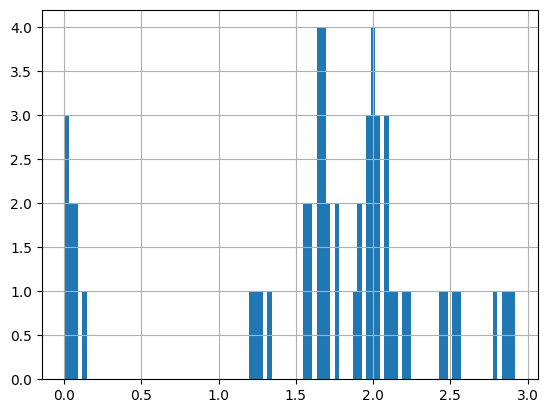

In [106]:
minEV_tidx_range = np.array([-1.44, -1.24]) / 0.04
# find the distribution of time since last wind change for the minEV range
EV_no_nan_around[(EV_no_nan_around['plot_tidx'] > minEV_tidx_range[0]) & (EV_no_nan_around['plot_tidx'] < minEV_tidx_range[1])]['time_since_last_wind_change'].hist(bins=100)

   plot_tidx         zeta
0        -40  3164.706817
1        -39  1148.840644
2        -38   459.717047
3        -37   197.734530
4        -36    58.316302
5        -35    34.680791
6        -34    27.555049
7        -33    21.751604
8        -32    23.164241
9        -31    28.031967
(1, 1)


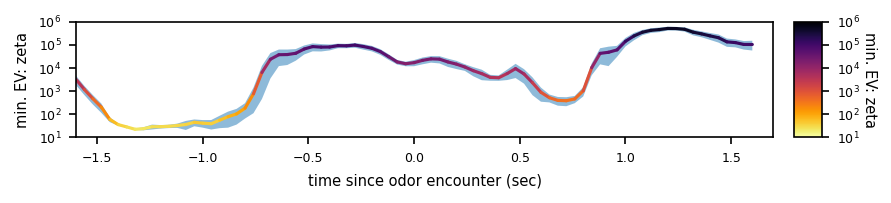

In [118]:
# plot average EV over time since last wind change with std ON plume
subset_df = EV_no_nan_around
subset_df = subset_df.groupby('plot_tidx')['zeta'].mean().reset_index()
print(subset_df.head(10))
subset_df['std'] = EV_no_nan_around.groupby('plot_tidx').std().reset_index()['zeta']
subset_df['ste'] = EV_no_nan_around.groupby('plot_tidx').sem().reset_index()['zeta']
subset_df['plot_tidx'] = subset_df['plot_tidx'] * 0.04
states = ['zeta']
n_state = len(states)
import matplotlib.pyplot as plt
import matplotlib as mpl
from pybounds import colorline
fig, ax = plt.subplots(n_state, 1, figsize=(6, n_state*1), dpi=150)
ax = np.atleast_2d(ax)
print(ax.shape)
cmap = 'inferno_r'

max_ev = np.max(subset_df['zeta'].values)
min_ev = np.min(subset_df['zeta'].values)

log_tick_high = int(np.ceil(np.log10(max_ev)))
log_tick_low = int(np.floor(np.log10(min_ev)))
cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

for n, state_name in enumerate(states):
    # colorline(x_sim['x'], x_sim['y'], subset_df[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    colorline(subset_df['plot_tidx'], subset_df[state_name].values, subset_df[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    # add std
    ax[n, 0].fill_between(subset_df['plot_tidx'], subset_df[state_name].values-subset_df['ste'], subset_df[state_name].values+subset_df['ste'], alpha=0.5)
    # Colorbar
    cax = ax[n, -1].inset_axes([1.03, 0.0, 0.04, 1.0])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                        ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    cbar.set_label('min. EV: ' + state_name, rotation=270, fontsize=7, labelpad=8)
    cbar.ax.tick_params(labelsize=6)

    ax[n, 0].set_ylim(10**log_tick_low, 10**log_tick_high)
    ax[n, 0].set_yscale('log')
    ax[n, 0].set_ylabel('min. EV: ' + state_name, fontsize=7)
    ax[n, 0].set_yticks(np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))


for a in ax.flat:
    a.tick_params(axis='both', labelsize=6)
    
for a in ax[:, 0]:
    a.set_xlabel('time since odor encounter (sec)', fontsize=7)
    a.set_xlim(subset_df['plot_tidx'].min(), subset_df['plot_tidx'].max() + 0.1)

# plot vline 
# for a in ax.flat:
    # a.axvline(-1.24, color='red', linestyle='--', linewidth=0.5)
    # a.axvline(-1.44, color='red', linestyle='--', linewidth=0.5)

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)

plt.show()

# minEV distribution

count    10608.000000
mean         2.790284
std          1.536150
min         -1.461013
25%          1.696542
50%          2.730609
75%          3.925763
max          5.988969
Name: zeta, dtype: float64

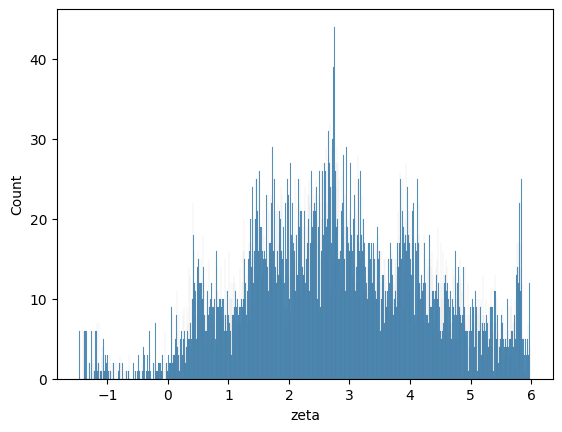

In [54]:
# log 10 transform EV_no_nan['zeta'] and then see its distribution
import seaborn as sns
sns.histplot(np.log10(EV_no_nan['zeta']), bins=1000)
np.log10(EV_no_nan['zeta']).describe()